In [5]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 

In [6]:
dataset = pd.read_csv('OSM_training_data/ensemble_dataset.csv')

In [7]:
dataset.head()

cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}
dataset['category_number'] = dataset['category_number'].map(cat_dict)

In [8]:
from keras.engine.topology import Layer

def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatibl|e with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)

class AttentionWithContext(Layer):
    """
    Attention operation, with a context/query vector, for temporal data.
    Supports Masking.
    Follows the work of Yang et al. [https://www.cs.cmu.edu/~diyiy/docs/naacl16.pdf]
    "Hierarchical Attention Networks for Document Classification"
    by using a context vector to assist the attention
    # Input shape
        3D tensor with shape: `(samples, steps, features)`.
    # Output shape
        2D tensor with shape: `(samples, features)`.
    How to use:
    Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
    The dimensions are inferred based on the output shape of the RNN.
    Note: The layer has been tested with Keras 2.0.6
    Example:
        model.add(LSTM(64, return_sequences=True))
        model.add(AttentionWithContext())
        # next add a Dense layer (for classification/regression) or whatever...
    """

    def __init__(self,
                 W_regularizer=None, u_regularizer=None, b_regularizer=None,
                 W_constraint=None, u_constraint=None, b_constraint=None,
                 bias=True, **kwargs):

        self.supports_masking = True
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.u_regularizer = regularizers.get(u_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.u_constraint = constraints.get(u_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(AttentionWithContext, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1], input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[-1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)

        self.u = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_u'.format(self.name),
                                 regularizer=self.u_regularizer,
                                 constraint=self.u_constraint)

        super(AttentionWithContext, self).build(input_shape)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        uit = dot_product(x, self.W)

        if self.bias:
            uit += self.b

        uit = K.tanh(uit)
        ait = dot_product(uit, self.u)

        a = K.exp(ait)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a
        
        # print(x.shape, a.shape)
        # (?, ?, 1528) (?, 250, 1)
        
        return [K.sum(weighted_input, axis=1), a]

    def compute_output_shape(self, input_shape):
        # return input_shape[0], input_shape[-1]
        return [(input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])]

Using TensorFlow backend.


In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
import nltk

In [10]:
# data = dataset.drop_duplicates(subset='name')
# data.head()

In [11]:
#features = ['name', 'bodytxt', 'tagtxt', 'price', 'category_number', 'combinedtxt_noNumSWPunc_morethan2char']
features = ['combinedtxt', "category_number"]
df = dataset[features]

# these rows contain erraneous values such as ??/??/??//?????////
df = df.drop(df.index[[7724, 23619, 23865]])


df.head()

combinedtxt category_number
0  Fat Burners & Thermogenics BLOODSHR3D (WAR EDI...           LEGIT
1  Vitamins Hylands Cell Salts #12 Silicea 30X Ta...           LEGIT
2  Vitamins Biotics Research - Detoxification 4oz...           LEGIT
3  HEWLETT-PACKARD C3903A Toner 4000 Page-Yield B...           LEGIT
4  Herbal Supplements Natural Natural Blood Press...           LEGIT

In [12]:
cat_dict_reverse = {'ADULT':0, 'COUNTERFEIT':1, 'LEGIT':2, 'PHARMA':3, 'SMOKE':4,'TMS':5, 'WEAPON':6}
df['category_number'] = df['category_number'].map(cat_dict_reverse)
df.head()


combinedtxt  category_number
0  Fat Burners & Thermogenics BLOODSHR3D (WAR EDI...                2
1  Vitamins Hylands Cell Salts #12 Silicea 30X Ta...                2
2  Vitamins Biotics Research - Detoxification 4oz...                2
3  HEWLETT-PACKARD C3903A Toner 4000 Page-Yield B...                2
4  Herbal Supplements Natural Natural Blood Press...                2

In [13]:
docs = df['combinedtxt'].values
labels = df['category_number'].values


In [164]:

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(labels)
encoded_Y = encoder.transform(labels)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

y

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [15]:
docs[0]

'Fat Burners & Thermogenics BLOODSHR3D (WAR EDITION) Ultra Premium Fat Burning & Thermogenic Fuel by Olympus Labs (GRAPE BUBBLEGUM) BLOODSHR3D (WAR EDITION) Ultra Premium Fat Burning & Thermogenic Fuel by Olympus Labs (GRAPE BUBBLEGUM) GRAPE BUBBLEGUM HAWAIIAN COLADA ORANGE STARKRUSH Product Description BLOODSHR3D WAR EDITION features the most advanced weight loss formula on the market today in a delicious powder form. BLOODSHR3D is designed to be an extreme fat burning powder that will not only burn fat but also provide excellent energy, mood elevation, and also suppress appetite making dieting that much easier! Feature Extreme Fat Burning Powder Advanced Weight Loss Formula Enhanced Energy & Mood Elevation Increased Appetite Suppression No Jitters (No Yohimbine) Brand : Olympus Labs MPN(PartNumber) : BSWAR EAN : 0736902318539 Package Dimensions(LxWxH) : 10x10x9cm ; 236 g '

In [16]:
embeddings_index = dict()
f = open('glove.6B.100d.txt')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [17]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

import re


for i, d in enumerate(docs):
    
    docs[i].replace("(", " ")
    docs[i].replace(")", " ")
    docs[i].replace("[", " ")
    docs[i].replace("]", " ")
    
    # remove all non-alphanumeric characters 
    docs[i] = re.sub('[^A-Za-z\s]+', '', docs[i])
    
    # a = docs[i].split(" ")
    
    # stopword removal 
    # a = [k for k in a if not k in stop_words]

        
    # docs[i] = " ".join(a)


In [18]:
docs[0]

'Fat Burners  Thermogenics BLOODSHRD WAR EDITION Ultra Premium Fat Burning  Thermogenic Fuel by Olympus Labs GRAPE BUBBLEGUM BLOODSHRD WAR EDITION Ultra Premium Fat Burning  Thermogenic Fuel by Olympus Labs GRAPE BUBBLEGUM GRAPE BUBBLEGUM HAWAIIAN COLADA ORANGE STARKRUSH Product Description BLOODSHRD WAR EDITION features the most advanced weight loss formula on the market today in a delicious powder form BLOODSHRD is designed to be an extreme fat burning powder that will not only burn fat but also provide excellent energy mood elevation and also suppress appetite making dieting that much easier Feature Extreme Fat Burning Powder Advanced Weight Loss Formula Enhanced Energy  Mood Elevation Increased Appetite Suppression No Jitters No Yohimbine Brand  Olympus Labs MPNPartNumber  BSWAR EAN   Package DimensionsLxWxH  xxcm   g '

In [19]:
new_sent = [] 
for i, word in enumerate(docs[0].lower().split(" ")):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        new_sent.append(word)

In [20]:
" ".join(new_sent)

'fat burners war edition ultra premium fat burning thermogenic fuel by olympus labs grape bubblegum war edition ultra premium fat burning thermogenic fuel by olympus labs grape bubblegum grape bubblegum hawaiian colada orange product description war edition features the most advanced weight loss formula on the market today in a delicious powder form is designed to be an extreme fat burning powder that will not only burn fat but also provide excellent energy mood elevation and also suppress appetite making dieting that much easier feature extreme fat burning powder advanced weight loss formula enhanced energy mood elevation increased appetite suppression no jitters no yohimbine brand olympus labs ean package g'

In [21]:
def filter_emb(sent):
    
    new_sent = [] 
    for i, word in enumerate(sent.lower().split(" ")):
        embedding_vector = embeddings_index.get(word)
        if len(word) <= 1:
            continue
        if embedding_vector is not None:
            new_sent.append(word)
            
    return " ".join(new_sent)
    
m = len(docs)
for i in range(m):
    print("{}/ {}".format(i, m))
    docs[i] = filter_emb(docs[i])

0/ 62815
1/ 62815
2/ 62815
3/ 62815
4/ 62815
5/ 62815
6/ 62815
7/ 62815
8/ 62815
9/ 62815
10/ 62815
11/ 62815
12/ 62815
13/ 62815
14/ 62815
15/ 62815
16/ 62815
17/ 62815
18/ 62815
19/ 62815
20/ 62815
21/ 62815
22/ 62815
23/ 62815
24/ 62815
25/ 62815
26/ 62815
27/ 62815
28/ 62815
29/ 62815
30/ 62815
31/ 62815
32/ 62815
33/ 62815
34/ 62815
35/ 62815
36/ 62815
37/ 62815
38/ 62815
39/ 62815
40/ 62815
41/ 62815
42/ 62815
43/ 62815
44/ 62815
45/ 62815
46/ 62815
47/ 62815
48/ 62815
49/ 62815
50/ 62815
51/ 62815
52/ 62815
53/ 62815
54/ 62815
55/ 62815
56/ 62815
57/ 62815
58/ 62815
59/ 62815
60/ 62815
61/ 62815
62/ 62815
63/ 62815
64/ 62815
65/ 62815
66/ 62815
67/ 62815
68/ 62815
69/ 62815
70/ 62815
71/ 62815
72/ 62815
73/ 62815
74/ 62815
75/ 62815
76/ 62815
77/ 62815
78/ 62815
79/ 62815
80/ 62815
81/ 62815
82/ 62815
83/ 62815
84/ 62815
85/ 62815
86/ 62815
87/ 62815
88/ 62815
89/ 62815
90/ 62815
91/ 62815
92/ 62815
93/ 62815
94/ 62815
95/ 62815
96/ 62815
97/ 62815
98/ 62815
99/ 62815
100/ 62815

1081/ 62815
1082/ 62815
1083/ 62815
1084/ 62815
1085/ 62815
1086/ 62815
1087/ 62815
1088/ 62815
1089/ 62815
1090/ 62815
1091/ 62815
1092/ 62815
1093/ 62815
1094/ 62815
1095/ 62815
1096/ 62815
1097/ 62815
1098/ 62815
1099/ 62815
1100/ 62815
1101/ 62815
1102/ 62815
1103/ 62815
1104/ 62815
1105/ 62815
1106/ 62815
1107/ 62815
1108/ 62815
1109/ 62815
1110/ 62815
1111/ 62815
1112/ 62815
1113/ 62815
1114/ 62815
1115/ 62815
1116/ 62815
1117/ 62815
1118/ 62815
1119/ 62815
1120/ 62815
1121/ 62815
1122/ 62815
1123/ 62815
1124/ 62815
1125/ 62815
1126/ 62815
1127/ 62815
1128/ 62815
1129/ 62815
1130/ 62815
1131/ 62815
1132/ 62815
1133/ 62815
1134/ 62815
1135/ 62815
1136/ 62815
1137/ 62815
1138/ 62815
1139/ 62815
1140/ 62815
1141/ 62815
1142/ 62815
1143/ 62815
1144/ 62815
1145/ 62815
1146/ 62815
1147/ 62815
1148/ 62815
1149/ 62815
1150/ 62815
1151/ 62815
1152/ 62815
1153/ 62815
1154/ 62815
1155/ 62815
1156/ 62815
1157/ 62815
1158/ 62815
1159/ 62815
1160/ 62815
1161/ 62815
1162/ 62815
1163/ 62815
1164

2423/ 62815
2424/ 62815
2425/ 62815
2426/ 62815
2427/ 62815
2428/ 62815
2429/ 62815
2430/ 62815
2431/ 62815
2432/ 62815
2433/ 62815
2434/ 62815
2435/ 62815
2436/ 62815
2437/ 62815
2438/ 62815
2439/ 62815
2440/ 62815
2441/ 62815
2442/ 62815
2443/ 62815
2444/ 62815
2445/ 62815
2446/ 62815
2447/ 62815
2448/ 62815
2449/ 62815
2450/ 62815
2451/ 62815
2452/ 62815
2453/ 62815
2454/ 62815
2455/ 62815
2456/ 62815
2457/ 62815
2458/ 62815
2459/ 62815
2460/ 62815
2461/ 62815
2462/ 62815
2463/ 62815
2464/ 62815
2465/ 62815
2466/ 62815
2467/ 62815
2468/ 62815
2469/ 62815
2470/ 62815
2471/ 62815
2472/ 62815
2473/ 62815
2474/ 62815
2475/ 62815
2476/ 62815
2477/ 62815
2478/ 62815
2479/ 62815
2480/ 62815
2481/ 62815
2482/ 62815
2483/ 62815
2484/ 62815
2485/ 62815
2486/ 62815
2487/ 62815
2488/ 62815
2489/ 62815
2490/ 62815
2491/ 62815
2492/ 62815
2493/ 62815
2494/ 62815
2495/ 62815
2496/ 62815
2497/ 62815
2498/ 62815
2499/ 62815
2500/ 62815
2501/ 62815
2502/ 62815
2503/ 62815
2504/ 62815
2505/ 62815
2506

3181/ 62815
3182/ 62815
3183/ 62815
3184/ 62815
3185/ 62815
3186/ 62815
3187/ 62815
3188/ 62815
3189/ 62815
3190/ 62815
3191/ 62815
3192/ 62815
3193/ 62815
3194/ 62815
3195/ 62815
3196/ 62815
3197/ 62815
3198/ 62815
3199/ 62815
3200/ 62815
3201/ 62815
3202/ 62815
3203/ 62815
3204/ 62815
3205/ 62815
3206/ 62815
3207/ 62815
3208/ 62815
3209/ 62815
3210/ 62815
3211/ 62815
3212/ 62815
3213/ 62815
3214/ 62815
3215/ 62815
3216/ 62815
3217/ 62815
3218/ 62815
3219/ 62815
3220/ 62815
3221/ 62815
3222/ 62815
3223/ 62815
3224/ 62815
3225/ 62815
3226/ 62815
3227/ 62815
3228/ 62815
3229/ 62815
3230/ 62815
3231/ 62815
3232/ 62815
3233/ 62815
3234/ 62815
3235/ 62815
3236/ 62815
3237/ 62815
3238/ 62815
3239/ 62815
3240/ 62815
3241/ 62815
3242/ 62815
3243/ 62815
3244/ 62815
3245/ 62815
3246/ 62815
3247/ 62815
3248/ 62815
3249/ 62815
3250/ 62815
3251/ 62815
3252/ 62815
3253/ 62815
3254/ 62815
3255/ 62815
3256/ 62815
3257/ 62815
3258/ 62815
3259/ 62815
3260/ 62815
3261/ 62815
3262/ 62815
3263/ 62815
3264

4332/ 62815
4333/ 62815
4334/ 62815
4335/ 62815
4336/ 62815
4337/ 62815
4338/ 62815
4339/ 62815
4340/ 62815
4341/ 62815
4342/ 62815
4343/ 62815
4344/ 62815
4345/ 62815
4346/ 62815
4347/ 62815
4348/ 62815
4349/ 62815
4350/ 62815
4351/ 62815
4352/ 62815
4353/ 62815
4354/ 62815
4355/ 62815
4356/ 62815
4357/ 62815
4358/ 62815
4359/ 62815
4360/ 62815
4361/ 62815
4362/ 62815
4363/ 62815
4364/ 62815
4365/ 62815
4366/ 62815
4367/ 62815
4368/ 62815
4369/ 62815
4370/ 62815
4371/ 62815
4372/ 62815
4373/ 62815
4374/ 62815
4375/ 62815
4376/ 62815
4377/ 62815
4378/ 62815
4379/ 62815
4380/ 62815
4381/ 62815
4382/ 62815
4383/ 62815
4384/ 62815
4385/ 62815
4386/ 62815
4387/ 62815
4388/ 62815
4389/ 62815
4390/ 62815
4391/ 62815
4392/ 62815
4393/ 62815
4394/ 62815
4395/ 62815
4396/ 62815
4397/ 62815
4398/ 62815
4399/ 62815
4400/ 62815
4401/ 62815
4402/ 62815
4403/ 62815
4404/ 62815
4405/ 62815
4406/ 62815
4407/ 62815
4408/ 62815
4409/ 62815
4410/ 62815
4411/ 62815
4412/ 62815
4413/ 62815
4414/ 62815
4415

5853/ 62815
5854/ 62815
5855/ 62815
5856/ 62815
5857/ 62815
5858/ 62815
5859/ 62815
5860/ 62815
5861/ 62815
5862/ 62815
5863/ 62815
5864/ 62815
5865/ 62815
5866/ 62815
5867/ 62815
5868/ 62815
5869/ 62815
5870/ 62815
5871/ 62815
5872/ 62815
5873/ 62815
5874/ 62815
5875/ 62815
5876/ 62815
5877/ 62815
5878/ 62815
5879/ 62815
5880/ 62815
5881/ 62815
5882/ 62815
5883/ 62815
5884/ 62815
5885/ 62815
5886/ 62815
5887/ 62815
5888/ 62815
5889/ 62815
5890/ 62815
5891/ 62815
5892/ 62815
5893/ 62815
5894/ 62815
5895/ 62815
5896/ 62815
5897/ 62815
5898/ 62815
5899/ 62815
5900/ 62815
5901/ 62815
5902/ 62815
5903/ 62815
5904/ 62815
5905/ 62815
5906/ 62815
5907/ 62815
5908/ 62815
5909/ 62815
5910/ 62815
5911/ 62815
5912/ 62815
5913/ 62815
5914/ 62815
5915/ 62815
5916/ 62815
5917/ 62815
5918/ 62815
5919/ 62815
5920/ 62815
5921/ 62815
5922/ 62815
5923/ 62815
5924/ 62815
5925/ 62815
5926/ 62815
5927/ 62815
5928/ 62815
5929/ 62815
5930/ 62815
5931/ 62815
5932/ 62815
5933/ 62815
5934/ 62815
5935/ 62815
5936

7352/ 62815
7353/ 62815
7354/ 62815
7355/ 62815
7356/ 62815
7357/ 62815
7358/ 62815
7359/ 62815
7360/ 62815
7361/ 62815
7362/ 62815
7363/ 62815
7364/ 62815
7365/ 62815
7366/ 62815
7367/ 62815
7368/ 62815
7369/ 62815
7370/ 62815
7371/ 62815
7372/ 62815
7373/ 62815
7374/ 62815
7375/ 62815
7376/ 62815
7377/ 62815
7378/ 62815
7379/ 62815
7380/ 62815
7381/ 62815
7382/ 62815
7383/ 62815
7384/ 62815
7385/ 62815
7386/ 62815
7387/ 62815
7388/ 62815
7389/ 62815
7390/ 62815
7391/ 62815
7392/ 62815
7393/ 62815
7394/ 62815
7395/ 62815
7396/ 62815
7397/ 62815
7398/ 62815
7399/ 62815
7400/ 62815
7401/ 62815
7402/ 62815
7403/ 62815
7404/ 62815
7405/ 62815
7406/ 62815
7407/ 62815
7408/ 62815
7409/ 62815
7410/ 62815
7411/ 62815
7412/ 62815
7413/ 62815
7414/ 62815
7415/ 62815
7416/ 62815
7417/ 62815
7418/ 62815
7419/ 62815
7420/ 62815
7421/ 62815
7422/ 62815
7423/ 62815
7424/ 62815
7425/ 62815
7426/ 62815
7427/ 62815
7428/ 62815
7429/ 62815
7430/ 62815
7431/ 62815
7432/ 62815
7433/ 62815
7434/ 62815
7435

9352/ 62815
9353/ 62815
9354/ 62815
9355/ 62815
9356/ 62815
9357/ 62815
9358/ 62815
9359/ 62815
9360/ 62815
9361/ 62815
9362/ 62815
9363/ 62815
9364/ 62815
9365/ 62815
9366/ 62815
9367/ 62815
9368/ 62815
9369/ 62815
9370/ 62815
9371/ 62815
9372/ 62815
9373/ 62815
9374/ 62815
9375/ 62815
9376/ 62815
9377/ 62815
9378/ 62815
9379/ 62815
9380/ 62815
9381/ 62815
9382/ 62815
9383/ 62815
9384/ 62815
9385/ 62815
9386/ 62815
9387/ 62815
9388/ 62815
9389/ 62815
9390/ 62815
9391/ 62815
9392/ 62815
9393/ 62815
9394/ 62815
9395/ 62815
9396/ 62815
9397/ 62815
9398/ 62815
9399/ 62815
9400/ 62815
9401/ 62815
9402/ 62815
9403/ 62815
9404/ 62815
9405/ 62815
9406/ 62815
9407/ 62815
9408/ 62815
9409/ 62815
9410/ 62815
9411/ 62815
9412/ 62815
9413/ 62815
9414/ 62815
9415/ 62815
9416/ 62815
9417/ 62815
9418/ 62815
9419/ 62815
9420/ 62815
9421/ 62815
9422/ 62815
9423/ 62815
9424/ 62815
9425/ 62815
9426/ 62815
9427/ 62815
9428/ 62815
9429/ 62815
9430/ 62815
9431/ 62815
9432/ 62815
9433/ 62815
9434/ 62815
9435

11351/ 62815
11352/ 62815
11353/ 62815
11354/ 62815
11355/ 62815
11356/ 62815
11357/ 62815
11358/ 62815
11359/ 62815
11360/ 62815
11361/ 62815
11362/ 62815
11363/ 62815
11364/ 62815
11365/ 62815
11366/ 62815
11367/ 62815
11368/ 62815
11369/ 62815
11370/ 62815
11371/ 62815
11372/ 62815
11373/ 62815
11374/ 62815
11375/ 62815
11376/ 62815
11377/ 62815
11378/ 62815
11379/ 62815
11380/ 62815
11381/ 62815
11382/ 62815
11383/ 62815
11384/ 62815
11385/ 62815
11386/ 62815
11387/ 62815
11388/ 62815
11389/ 62815
11390/ 62815
11391/ 62815
11392/ 62815
11393/ 62815
11394/ 62815
11395/ 62815
11396/ 62815
11397/ 62815
11398/ 62815
11399/ 62815
11400/ 62815
11401/ 62815
11402/ 62815
11403/ 62815
11404/ 62815
11405/ 62815
11406/ 62815
11407/ 62815
11408/ 62815
11409/ 62815
11410/ 62815
11411/ 62815
11412/ 62815
11413/ 62815
11414/ 62815
11415/ 62815
11416/ 62815
11417/ 62815
11418/ 62815
11419/ 62815
11420/ 62815
11421/ 62815
11422/ 62815
11423/ 62815
11424/ 62815
11425/ 62815
11426/ 62815
11427/ 62815

13351/ 62815
13352/ 62815
13353/ 62815
13354/ 62815
13355/ 62815
13356/ 62815
13357/ 62815
13358/ 62815
13359/ 62815
13360/ 62815
13361/ 62815
13362/ 62815
13363/ 62815
13364/ 62815
13365/ 62815
13366/ 62815
13367/ 62815
13368/ 62815
13369/ 62815
13370/ 62815
13371/ 62815
13372/ 62815
13373/ 62815
13374/ 62815
13375/ 62815
13376/ 62815
13377/ 62815
13378/ 62815
13379/ 62815
13380/ 62815
13381/ 62815
13382/ 62815
13383/ 62815
13384/ 62815
13385/ 62815
13386/ 62815
13387/ 62815
13388/ 62815
13389/ 62815
13390/ 62815
13391/ 62815
13392/ 62815
13393/ 62815
13394/ 62815
13395/ 62815
13396/ 62815
13397/ 62815
13398/ 62815
13399/ 62815
13400/ 62815
13401/ 62815
13402/ 62815
13403/ 62815
13404/ 62815
13405/ 62815
13406/ 62815
13407/ 62815
13408/ 62815
13409/ 62815
13410/ 62815
13411/ 62815
13412/ 62815
13413/ 62815
13414/ 62815
13415/ 62815
13416/ 62815
13417/ 62815
13418/ 62815
13419/ 62815
13420/ 62815
13421/ 62815
13422/ 62815
13423/ 62815
13424/ 62815
13425/ 62815
13426/ 62815
13427/ 62815

14799/ 62815
14800/ 62815
14801/ 62815
14802/ 62815
14803/ 62815
14804/ 62815
14805/ 62815
14806/ 62815
14807/ 62815
14808/ 62815
14809/ 62815
14810/ 62815
14811/ 62815
14812/ 62815
14813/ 62815
14814/ 62815
14815/ 62815
14816/ 62815
14817/ 62815
14818/ 62815
14819/ 62815
14820/ 62815
14821/ 62815
14822/ 62815
14823/ 62815
14824/ 62815
14825/ 62815
14826/ 62815
14827/ 62815
14828/ 62815
14829/ 62815
14830/ 62815
14831/ 62815
14832/ 62815
14833/ 62815
14834/ 62815
14835/ 62815
14836/ 62815
14837/ 62815
14838/ 62815
14839/ 62815
14840/ 62815
14841/ 62815
14842/ 62815
14843/ 62815
14844/ 62815
14845/ 62815
14846/ 62815
14847/ 62815
14848/ 62815
14849/ 62815
14850/ 62815
14851/ 62815
14852/ 62815
14853/ 62815
14854/ 62815
14855/ 62815
14856/ 62815
14857/ 62815
14858/ 62815
14859/ 62815
14860/ 62815
14861/ 62815
14862/ 62815
14863/ 62815
14864/ 62815
14865/ 62815
14866/ 62815
14867/ 62815
14868/ 62815
14869/ 62815
14870/ 62815
14871/ 62815
14872/ 62815
14873/ 62815
14874/ 62815
14875/ 62815

16662/ 62815
16663/ 62815
16664/ 62815
16665/ 62815
16666/ 62815
16667/ 62815
16668/ 62815
16669/ 62815
16670/ 62815
16671/ 62815
16672/ 62815
16673/ 62815
16674/ 62815
16675/ 62815
16676/ 62815
16677/ 62815
16678/ 62815
16679/ 62815
16680/ 62815
16681/ 62815
16682/ 62815
16683/ 62815
16684/ 62815
16685/ 62815
16686/ 62815
16687/ 62815
16688/ 62815
16689/ 62815
16690/ 62815
16691/ 62815
16692/ 62815
16693/ 62815
16694/ 62815
16695/ 62815
16696/ 62815
16697/ 62815
16698/ 62815
16699/ 62815
16700/ 62815
16701/ 62815
16702/ 62815
16703/ 62815
16704/ 62815
16705/ 62815
16706/ 62815
16707/ 62815
16708/ 62815
16709/ 62815
16710/ 62815
16711/ 62815
16712/ 62815
16713/ 62815
16714/ 62815
16715/ 62815
16716/ 62815
16717/ 62815
16718/ 62815
16719/ 62815
16720/ 62815
16721/ 62815
16722/ 62815
16723/ 62815
16724/ 62815
16725/ 62815
16726/ 62815
16727/ 62815
16728/ 62815
16729/ 62815
16730/ 62815
16731/ 62815
16732/ 62815
16733/ 62815
16734/ 62815
16735/ 62815
16736/ 62815
16737/ 62815
16738/ 62815

18322/ 62815
18323/ 62815
18324/ 62815
18325/ 62815
18326/ 62815
18327/ 62815
18328/ 62815
18329/ 62815
18330/ 62815
18331/ 62815
18332/ 62815
18333/ 62815
18334/ 62815
18335/ 62815
18336/ 62815
18337/ 62815
18338/ 62815
18339/ 62815
18340/ 62815
18341/ 62815
18342/ 62815
18343/ 62815
18344/ 62815
18345/ 62815
18346/ 62815
18347/ 62815
18348/ 62815
18349/ 62815
18350/ 62815
18351/ 62815
18352/ 62815
18353/ 62815
18354/ 62815
18355/ 62815
18356/ 62815
18357/ 62815
18358/ 62815
18359/ 62815
18360/ 62815
18361/ 62815
18362/ 62815
18363/ 62815
18364/ 62815
18365/ 62815
18366/ 62815
18367/ 62815
18368/ 62815
18369/ 62815
18370/ 62815
18371/ 62815
18372/ 62815
18373/ 62815
18374/ 62815
18375/ 62815
18376/ 62815
18377/ 62815
18378/ 62815
18379/ 62815
18380/ 62815
18381/ 62815
18382/ 62815
18383/ 62815
18384/ 62815
18385/ 62815
18386/ 62815
18387/ 62815
18388/ 62815
18389/ 62815
18390/ 62815
18391/ 62815
18392/ 62815
18393/ 62815
18394/ 62815
18395/ 62815
18396/ 62815
18397/ 62815
18398/ 62815

20849/ 62815
20850/ 62815
20851/ 62815
20852/ 62815
20853/ 62815
20854/ 62815
20855/ 62815
20856/ 62815
20857/ 62815
20858/ 62815
20859/ 62815
20860/ 62815
20861/ 62815
20862/ 62815
20863/ 62815
20864/ 62815
20865/ 62815
20866/ 62815
20867/ 62815
20868/ 62815
20869/ 62815
20870/ 62815
20871/ 62815
20872/ 62815
20873/ 62815
20874/ 62815
20875/ 62815
20876/ 62815
20877/ 62815
20878/ 62815
20879/ 62815
20880/ 62815
20881/ 62815
20882/ 62815
20883/ 62815
20884/ 62815
20885/ 62815
20886/ 62815
20887/ 62815
20888/ 62815
20889/ 62815
20890/ 62815
20891/ 62815
20892/ 62815
20893/ 62815
20894/ 62815
20895/ 62815
20896/ 62815
20897/ 62815
20898/ 62815
20899/ 62815
20900/ 62815
20901/ 62815
20902/ 62815
20903/ 62815
20904/ 62815
20905/ 62815
20906/ 62815
20907/ 62815
20908/ 62815
20909/ 62815
20910/ 62815
20911/ 62815
20912/ 62815
20913/ 62815
20914/ 62815
20915/ 62815
20916/ 62815
20917/ 62815
20918/ 62815
20919/ 62815
20920/ 62815
20921/ 62815
20922/ 62815
20923/ 62815
20924/ 62815
20925/ 62815

22428/ 62815
22429/ 62815
22430/ 62815
22431/ 62815
22432/ 62815
22433/ 62815
22434/ 62815
22435/ 62815
22436/ 62815
22437/ 62815
22438/ 62815
22439/ 62815
22440/ 62815
22441/ 62815
22442/ 62815
22443/ 62815
22444/ 62815
22445/ 62815
22446/ 62815
22447/ 62815
22448/ 62815
22449/ 62815
22450/ 62815
22451/ 62815
22452/ 62815
22453/ 62815
22454/ 62815
22455/ 62815
22456/ 62815
22457/ 62815
22458/ 62815
22459/ 62815
22460/ 62815
22461/ 62815
22462/ 62815
22463/ 62815
22464/ 62815
22465/ 62815
22466/ 62815
22467/ 62815
22468/ 62815
22469/ 62815
22470/ 62815
22471/ 62815
22472/ 62815
22473/ 62815
22474/ 62815
22475/ 62815
22476/ 62815
22477/ 62815
22478/ 62815
22479/ 62815
22480/ 62815
22481/ 62815
22482/ 62815
22483/ 62815
22484/ 62815
22485/ 62815
22486/ 62815
22487/ 62815
22488/ 62815
22489/ 62815
22490/ 62815
22491/ 62815
22492/ 62815
22493/ 62815
22494/ 62815
22495/ 62815
22496/ 62815
22497/ 62815
22498/ 62815
22499/ 62815
22500/ 62815
22501/ 62815
22502/ 62815
22503/ 62815
22504/ 62815

24319/ 62815
24320/ 62815
24321/ 62815
24322/ 62815
24323/ 62815
24324/ 62815
24325/ 62815
24326/ 62815
24327/ 62815
24328/ 62815
24329/ 62815
24330/ 62815
24331/ 62815
24332/ 62815
24333/ 62815
24334/ 62815
24335/ 62815
24336/ 62815
24337/ 62815
24338/ 62815
24339/ 62815
24340/ 62815
24341/ 62815
24342/ 62815
24343/ 62815
24344/ 62815
24345/ 62815
24346/ 62815
24347/ 62815
24348/ 62815
24349/ 62815
24350/ 62815
24351/ 62815
24352/ 62815
24353/ 62815
24354/ 62815
24355/ 62815
24356/ 62815
24357/ 62815
24358/ 62815
24359/ 62815
24360/ 62815
24361/ 62815
24362/ 62815
24363/ 62815
24364/ 62815
24365/ 62815
24366/ 62815
24367/ 62815
24368/ 62815
24369/ 62815
24370/ 62815
24371/ 62815
24372/ 62815
24373/ 62815
24374/ 62815
24375/ 62815
24376/ 62815
24377/ 62815
24378/ 62815
24379/ 62815
24380/ 62815
24381/ 62815
24382/ 62815
24383/ 62815
24384/ 62815
24385/ 62815
24386/ 62815
24387/ 62815
24388/ 62815
24389/ 62815
24390/ 62815
24391/ 62815
24392/ 62815
24393/ 62815
24394/ 62815
24395/ 62815

25373/ 62815
25374/ 62815
25375/ 62815
25376/ 62815
25377/ 62815
25378/ 62815
25379/ 62815
25380/ 62815
25381/ 62815
25382/ 62815
25383/ 62815
25384/ 62815
25385/ 62815
25386/ 62815
25387/ 62815
25388/ 62815
25389/ 62815
25390/ 62815
25391/ 62815
25392/ 62815
25393/ 62815
25394/ 62815
25395/ 62815
25396/ 62815
25397/ 62815
25398/ 62815
25399/ 62815
25400/ 62815
25401/ 62815
25402/ 62815
25403/ 62815
25404/ 62815
25405/ 62815
25406/ 62815
25407/ 62815
25408/ 62815
25409/ 62815
25410/ 62815
25411/ 62815
25412/ 62815
25413/ 62815
25414/ 62815
25415/ 62815
25416/ 62815
25417/ 62815
25418/ 62815
25419/ 62815
25420/ 62815
25421/ 62815
25422/ 62815
25423/ 62815
25424/ 62815
25425/ 62815
25426/ 62815
25427/ 62815
25428/ 62815
25429/ 62815
25430/ 62815
25431/ 62815
25432/ 62815
25433/ 62815
25434/ 62815
25435/ 62815
25436/ 62815
25437/ 62815
25438/ 62815
25439/ 62815
25440/ 62815
25441/ 62815
25442/ 62815
25443/ 62815
25444/ 62815
25445/ 62815
25446/ 62815
25447/ 62815
25448/ 62815
25449/ 62815

26847/ 62815
26848/ 62815
26849/ 62815
26850/ 62815
26851/ 62815
26852/ 62815
26853/ 62815
26854/ 62815
26855/ 62815
26856/ 62815
26857/ 62815
26858/ 62815
26859/ 62815
26860/ 62815
26861/ 62815
26862/ 62815
26863/ 62815
26864/ 62815
26865/ 62815
26866/ 62815
26867/ 62815
26868/ 62815
26869/ 62815
26870/ 62815
26871/ 62815
26872/ 62815
26873/ 62815
26874/ 62815
26875/ 62815
26876/ 62815
26877/ 62815
26878/ 62815
26879/ 62815
26880/ 62815
26881/ 62815
26882/ 62815
26883/ 62815
26884/ 62815
26885/ 62815
26886/ 62815
26887/ 62815
26888/ 62815
26889/ 62815
26890/ 62815
26891/ 62815
26892/ 62815
26893/ 62815
26894/ 62815
26895/ 62815
26896/ 62815
26897/ 62815
26898/ 62815
26899/ 62815
26900/ 62815
26901/ 62815
26902/ 62815
26903/ 62815
26904/ 62815
26905/ 62815
26906/ 62815
26907/ 62815
26908/ 62815
26909/ 62815
26910/ 62815
26911/ 62815
26912/ 62815
26913/ 62815
26914/ 62815
26915/ 62815
26916/ 62815
26917/ 62815
26918/ 62815
26919/ 62815
26920/ 62815
26921/ 62815
26922/ 62815
26923/ 62815

28133/ 62815
28134/ 62815
28135/ 62815
28136/ 62815
28137/ 62815
28138/ 62815
28139/ 62815
28140/ 62815
28141/ 62815
28142/ 62815
28143/ 62815
28144/ 62815
28145/ 62815
28146/ 62815
28147/ 62815
28148/ 62815
28149/ 62815
28150/ 62815
28151/ 62815
28152/ 62815
28153/ 62815
28154/ 62815
28155/ 62815
28156/ 62815
28157/ 62815
28158/ 62815
28159/ 62815
28160/ 62815
28161/ 62815
28162/ 62815
28163/ 62815
28164/ 62815
28165/ 62815
28166/ 62815
28167/ 62815
28168/ 62815
28169/ 62815
28170/ 62815
28171/ 62815
28172/ 62815
28173/ 62815
28174/ 62815
28175/ 62815
28176/ 62815
28177/ 62815
28178/ 62815
28179/ 62815
28180/ 62815
28181/ 62815
28182/ 62815
28183/ 62815
28184/ 62815
28185/ 62815
28186/ 62815
28187/ 62815
28188/ 62815
28189/ 62815
28190/ 62815
28191/ 62815
28192/ 62815
28193/ 62815
28194/ 62815
28195/ 62815
28196/ 62815
28197/ 62815
28198/ 62815
28199/ 62815
28200/ 62815
28201/ 62815
28202/ 62815
28203/ 62815
28204/ 62815
28205/ 62815
28206/ 62815
28207/ 62815
28208/ 62815
28209/ 62815

29846/ 62815
29847/ 62815
29848/ 62815
29849/ 62815
29850/ 62815
29851/ 62815
29852/ 62815
29853/ 62815
29854/ 62815
29855/ 62815
29856/ 62815
29857/ 62815
29858/ 62815
29859/ 62815
29860/ 62815
29861/ 62815
29862/ 62815
29863/ 62815
29864/ 62815
29865/ 62815
29866/ 62815
29867/ 62815
29868/ 62815
29869/ 62815
29870/ 62815
29871/ 62815
29872/ 62815
29873/ 62815
29874/ 62815
29875/ 62815
29876/ 62815
29877/ 62815
29878/ 62815
29879/ 62815
29880/ 62815
29881/ 62815
29882/ 62815
29883/ 62815
29884/ 62815
29885/ 62815
29886/ 62815
29887/ 62815
29888/ 62815
29889/ 62815
29890/ 62815
29891/ 62815
29892/ 62815
29893/ 62815
29894/ 62815
29895/ 62815
29896/ 62815
29897/ 62815
29898/ 62815
29899/ 62815
29900/ 62815
29901/ 62815
29902/ 62815
29903/ 62815
29904/ 62815
29905/ 62815
29906/ 62815
29907/ 62815
29908/ 62815
29909/ 62815
29910/ 62815
29911/ 62815
29912/ 62815
29913/ 62815
29914/ 62815
29915/ 62815
29916/ 62815
29917/ 62815
29918/ 62815
29919/ 62815
29920/ 62815
29921/ 62815
29922/ 62815

31106/ 62815
31107/ 62815
31108/ 62815
31109/ 62815
31110/ 62815
31111/ 62815
31112/ 62815
31113/ 62815
31114/ 62815
31115/ 62815
31116/ 62815
31117/ 62815
31118/ 62815
31119/ 62815
31120/ 62815
31121/ 62815
31122/ 62815
31123/ 62815
31124/ 62815
31125/ 62815
31126/ 62815
31127/ 62815
31128/ 62815
31129/ 62815
31130/ 62815
31131/ 62815
31132/ 62815
31133/ 62815
31134/ 62815
31135/ 62815
31136/ 62815
31137/ 62815
31138/ 62815
31139/ 62815
31140/ 62815
31141/ 62815
31142/ 62815
31143/ 62815
31144/ 62815
31145/ 62815
31146/ 62815
31147/ 62815
31148/ 62815
31149/ 62815
31150/ 62815
31151/ 62815
31152/ 62815
31153/ 62815
31154/ 62815
31155/ 62815
31156/ 62815
31157/ 62815
31158/ 62815
31159/ 62815
31160/ 62815
31161/ 62815
31162/ 62815
31163/ 62815
31164/ 62815
31165/ 62815
31166/ 62815
31167/ 62815
31168/ 62815
31169/ 62815
31170/ 62815
31171/ 62815
31172/ 62815
31173/ 62815
31174/ 62815
31175/ 62815
31176/ 62815
31177/ 62815
31178/ 62815
31179/ 62815
31180/ 62815
31181/ 62815
31182/ 62815

32557/ 62815
32558/ 62815
32559/ 62815
32560/ 62815
32561/ 62815
32562/ 62815
32563/ 62815
32564/ 62815
32565/ 62815
32566/ 62815
32567/ 62815
32568/ 62815
32569/ 62815
32570/ 62815
32571/ 62815
32572/ 62815
32573/ 62815
32574/ 62815
32575/ 62815
32576/ 62815
32577/ 62815
32578/ 62815
32579/ 62815
32580/ 62815
32581/ 62815
32582/ 62815
32583/ 62815
32584/ 62815
32585/ 62815
32586/ 62815
32587/ 62815
32588/ 62815
32589/ 62815
32590/ 62815
32591/ 62815
32592/ 62815
32593/ 62815
32594/ 62815
32595/ 62815
32596/ 62815
32597/ 62815
32598/ 62815
32599/ 62815
32600/ 62815
32601/ 62815
32602/ 62815
32603/ 62815
32604/ 62815
32605/ 62815
32606/ 62815
32607/ 62815
32608/ 62815
32609/ 62815
32610/ 62815
32611/ 62815
32612/ 62815
32613/ 62815
32614/ 62815
32615/ 62815
32616/ 62815
32617/ 62815
32618/ 62815
32619/ 62815
32620/ 62815
32621/ 62815
32622/ 62815
32623/ 62815
32624/ 62815
32625/ 62815
32626/ 62815
32627/ 62815
32628/ 62815
32629/ 62815
32630/ 62815
32631/ 62815
32632/ 62815
32633/ 62815

34344/ 62815
34345/ 62815
34346/ 62815
34347/ 62815
34348/ 62815
34349/ 62815
34350/ 62815
34351/ 62815
34352/ 62815
34353/ 62815
34354/ 62815
34355/ 62815
34356/ 62815
34357/ 62815
34358/ 62815
34359/ 62815
34360/ 62815
34361/ 62815
34362/ 62815
34363/ 62815
34364/ 62815
34365/ 62815
34366/ 62815
34367/ 62815
34368/ 62815
34369/ 62815
34370/ 62815
34371/ 62815
34372/ 62815
34373/ 62815
34374/ 62815
34375/ 62815
34376/ 62815
34377/ 62815
34378/ 62815
34379/ 62815
34380/ 62815
34381/ 62815
34382/ 62815
34383/ 62815
34384/ 62815
34385/ 62815
34386/ 62815
34387/ 62815
34388/ 62815
34389/ 62815
34390/ 62815
34391/ 62815
34392/ 62815
34393/ 62815
34394/ 62815
34395/ 62815
34396/ 62815
34397/ 62815
34398/ 62815
34399/ 62815
34400/ 62815
34401/ 62815
34402/ 62815
34403/ 62815
34404/ 62815
34405/ 62815
34406/ 62815
34407/ 62815
34408/ 62815
34409/ 62815
34410/ 62815
34411/ 62815
34412/ 62815
34413/ 62815
34414/ 62815
34415/ 62815
34416/ 62815
34417/ 62815
34418/ 62815
34419/ 62815
34420/ 62815

35844/ 62815
35845/ 62815
35846/ 62815
35847/ 62815
35848/ 62815
35849/ 62815
35850/ 62815
35851/ 62815
35852/ 62815
35853/ 62815
35854/ 62815
35855/ 62815
35856/ 62815
35857/ 62815
35858/ 62815
35859/ 62815
35860/ 62815
35861/ 62815
35862/ 62815
35863/ 62815
35864/ 62815
35865/ 62815
35866/ 62815
35867/ 62815
35868/ 62815
35869/ 62815
35870/ 62815
35871/ 62815
35872/ 62815
35873/ 62815
35874/ 62815
35875/ 62815
35876/ 62815
35877/ 62815
35878/ 62815
35879/ 62815
35880/ 62815
35881/ 62815
35882/ 62815
35883/ 62815
35884/ 62815
35885/ 62815
35886/ 62815
35887/ 62815
35888/ 62815
35889/ 62815
35890/ 62815
35891/ 62815
35892/ 62815
35893/ 62815
35894/ 62815
35895/ 62815
35896/ 62815
35897/ 62815
35898/ 62815
35899/ 62815
35900/ 62815
35901/ 62815
35902/ 62815
35903/ 62815
35904/ 62815
35905/ 62815
35906/ 62815
35907/ 62815
35908/ 62815
35909/ 62815
35910/ 62815
35911/ 62815
35912/ 62815
35913/ 62815
35914/ 62815
35915/ 62815
35916/ 62815
35917/ 62815
35918/ 62815
35919/ 62815
35920/ 62815

37124/ 62815
37125/ 62815
37126/ 62815
37127/ 62815
37128/ 62815
37129/ 62815
37130/ 62815
37131/ 62815
37132/ 62815
37133/ 62815
37134/ 62815
37135/ 62815
37136/ 62815
37137/ 62815
37138/ 62815
37139/ 62815
37140/ 62815
37141/ 62815
37142/ 62815
37143/ 62815
37144/ 62815
37145/ 62815
37146/ 62815
37147/ 62815
37148/ 62815
37149/ 62815
37150/ 62815
37151/ 62815
37152/ 62815
37153/ 62815
37154/ 62815
37155/ 62815
37156/ 62815
37157/ 62815
37158/ 62815
37159/ 62815
37160/ 62815
37161/ 62815
37162/ 62815
37163/ 62815
37164/ 62815
37165/ 62815
37166/ 62815
37167/ 62815
37168/ 62815
37169/ 62815
37170/ 62815
37171/ 62815
37172/ 62815
37173/ 62815
37174/ 62815
37175/ 62815
37176/ 62815
37177/ 62815
37178/ 62815
37179/ 62815
37180/ 62815
37181/ 62815
37182/ 62815
37183/ 62815
37184/ 62815
37185/ 62815
37186/ 62815
37187/ 62815
37188/ 62815
37189/ 62815
37190/ 62815
37191/ 62815
37192/ 62815
37193/ 62815
37194/ 62815
37195/ 62815
37196/ 62815
37197/ 62815
37198/ 62815
37199/ 62815
37200/ 62815

38843/ 62815
38844/ 62815
38845/ 62815
38846/ 62815
38847/ 62815
38848/ 62815
38849/ 62815
38850/ 62815
38851/ 62815
38852/ 62815
38853/ 62815
38854/ 62815
38855/ 62815
38856/ 62815
38857/ 62815
38858/ 62815
38859/ 62815
38860/ 62815
38861/ 62815
38862/ 62815
38863/ 62815
38864/ 62815
38865/ 62815
38866/ 62815
38867/ 62815
38868/ 62815
38869/ 62815
38870/ 62815
38871/ 62815
38872/ 62815
38873/ 62815
38874/ 62815
38875/ 62815
38876/ 62815
38877/ 62815
38878/ 62815
38879/ 62815
38880/ 62815
38881/ 62815
38882/ 62815
38883/ 62815
38884/ 62815
38885/ 62815
38886/ 62815
38887/ 62815
38888/ 62815
38889/ 62815
38890/ 62815
38891/ 62815
38892/ 62815
38893/ 62815
38894/ 62815
38895/ 62815
38896/ 62815
38897/ 62815
38898/ 62815
38899/ 62815
38900/ 62815
38901/ 62815
38902/ 62815
38903/ 62815
38904/ 62815
38905/ 62815
38906/ 62815
38907/ 62815
38908/ 62815
38909/ 62815
38910/ 62815
38911/ 62815
38912/ 62815
38913/ 62815
38914/ 62815
38915/ 62815
38916/ 62815
38917/ 62815
38918/ 62815
38919/ 62815

40842/ 62815
40843/ 62815
40844/ 62815
40845/ 62815
40846/ 62815
40847/ 62815
40848/ 62815
40849/ 62815
40850/ 62815
40851/ 62815
40852/ 62815
40853/ 62815
40854/ 62815
40855/ 62815
40856/ 62815
40857/ 62815
40858/ 62815
40859/ 62815
40860/ 62815
40861/ 62815
40862/ 62815
40863/ 62815
40864/ 62815
40865/ 62815
40866/ 62815
40867/ 62815
40868/ 62815
40869/ 62815
40870/ 62815
40871/ 62815
40872/ 62815
40873/ 62815
40874/ 62815
40875/ 62815
40876/ 62815
40877/ 62815
40878/ 62815
40879/ 62815
40880/ 62815
40881/ 62815
40882/ 62815
40883/ 62815
40884/ 62815
40885/ 62815
40886/ 62815
40887/ 62815
40888/ 62815
40889/ 62815
40890/ 62815
40891/ 62815
40892/ 62815
40893/ 62815
40894/ 62815
40895/ 62815
40896/ 62815
40897/ 62815
40898/ 62815
40899/ 62815
40900/ 62815
40901/ 62815
40902/ 62815
40903/ 62815
40904/ 62815
40905/ 62815
40906/ 62815
40907/ 62815
40908/ 62815
40909/ 62815
40910/ 62815
40911/ 62815
40912/ 62815
40913/ 62815
40914/ 62815
40915/ 62815
40916/ 62815
40917/ 62815
40918/ 62815

42842/ 62815
42843/ 62815
42844/ 62815
42845/ 62815
42846/ 62815
42847/ 62815
42848/ 62815
42849/ 62815
42850/ 62815
42851/ 62815
42852/ 62815
42853/ 62815
42854/ 62815
42855/ 62815
42856/ 62815
42857/ 62815
42858/ 62815
42859/ 62815
42860/ 62815
42861/ 62815
42862/ 62815
42863/ 62815
42864/ 62815
42865/ 62815
42866/ 62815
42867/ 62815
42868/ 62815
42869/ 62815
42870/ 62815
42871/ 62815
42872/ 62815
42873/ 62815
42874/ 62815
42875/ 62815
42876/ 62815
42877/ 62815
42878/ 62815
42879/ 62815
42880/ 62815
42881/ 62815
42882/ 62815
42883/ 62815
42884/ 62815
42885/ 62815
42886/ 62815
42887/ 62815
42888/ 62815
42889/ 62815
42890/ 62815
42891/ 62815
42892/ 62815
42893/ 62815
42894/ 62815
42895/ 62815
42896/ 62815
42897/ 62815
42898/ 62815
42899/ 62815
42900/ 62815
42901/ 62815
42902/ 62815
42903/ 62815
42904/ 62815
42905/ 62815
42906/ 62815
42907/ 62815
42908/ 62815
42909/ 62815
42910/ 62815
42911/ 62815
42912/ 62815
42913/ 62815
42914/ 62815
42915/ 62815
42916/ 62815
42917/ 62815
42918/ 62815

44841/ 62815
44842/ 62815
44843/ 62815
44844/ 62815
44845/ 62815
44846/ 62815
44847/ 62815
44848/ 62815
44849/ 62815
44850/ 62815
44851/ 62815
44852/ 62815
44853/ 62815
44854/ 62815
44855/ 62815
44856/ 62815
44857/ 62815
44858/ 62815
44859/ 62815
44860/ 62815
44861/ 62815
44862/ 62815
44863/ 62815
44864/ 62815
44865/ 62815
44866/ 62815
44867/ 62815
44868/ 62815
44869/ 62815
44870/ 62815
44871/ 62815
44872/ 62815
44873/ 62815
44874/ 62815
44875/ 62815
44876/ 62815
44877/ 62815
44878/ 62815
44879/ 62815
44880/ 62815
44881/ 62815
44882/ 62815
44883/ 62815
44884/ 62815
44885/ 62815
44886/ 62815
44887/ 62815
44888/ 62815
44889/ 62815
44890/ 62815
44891/ 62815
44892/ 62815
44893/ 62815
44894/ 62815
44895/ 62815
44896/ 62815
44897/ 62815
44898/ 62815
44899/ 62815
44900/ 62815
44901/ 62815
44902/ 62815
44903/ 62815
44904/ 62815
44905/ 62815
44906/ 62815
44907/ 62815
44908/ 62815
44909/ 62815
44910/ 62815
44911/ 62815
44912/ 62815
44913/ 62815
44914/ 62815
44915/ 62815
44916/ 62815
44917/ 62815

46176/ 62815
46177/ 62815
46178/ 62815
46179/ 62815
46180/ 62815
46181/ 62815
46182/ 62815
46183/ 62815
46184/ 62815
46185/ 62815
46186/ 62815
46187/ 62815
46188/ 62815
46189/ 62815
46190/ 62815
46191/ 62815
46192/ 62815
46193/ 62815
46194/ 62815
46195/ 62815
46196/ 62815
46197/ 62815
46198/ 62815
46199/ 62815
46200/ 62815
46201/ 62815
46202/ 62815
46203/ 62815
46204/ 62815
46205/ 62815
46206/ 62815
46207/ 62815
46208/ 62815
46209/ 62815
46210/ 62815
46211/ 62815
46212/ 62815
46213/ 62815
46214/ 62815
46215/ 62815
46216/ 62815
46217/ 62815
46218/ 62815
46219/ 62815
46220/ 62815
46221/ 62815
46222/ 62815
46223/ 62815
46224/ 62815
46225/ 62815
46226/ 62815
46227/ 62815
46228/ 62815
46229/ 62815
46230/ 62815
46231/ 62815
46232/ 62815
46233/ 62815
46234/ 62815
46235/ 62815
46236/ 62815
46237/ 62815
46238/ 62815
46239/ 62815
46240/ 62815
46241/ 62815
46242/ 62815
46243/ 62815
46244/ 62815
46245/ 62815
46246/ 62815
46247/ 62815
46248/ 62815
46249/ 62815
46250/ 62815
46251/ 62815
46252/ 62815

47761/ 62815
47762/ 62815
47763/ 62815
47764/ 62815
47765/ 62815
47766/ 62815
47767/ 62815
47768/ 62815
47769/ 62815
47770/ 62815
47771/ 62815
47772/ 62815
47773/ 62815
47774/ 62815
47775/ 62815
47776/ 62815
47777/ 62815
47778/ 62815
47779/ 62815
47780/ 62815
47781/ 62815
47782/ 62815
47783/ 62815
47784/ 62815
47785/ 62815
47786/ 62815
47787/ 62815
47788/ 62815
47789/ 62815
47790/ 62815
47791/ 62815
47792/ 62815
47793/ 62815
47794/ 62815
47795/ 62815
47796/ 62815
47797/ 62815
47798/ 62815
47799/ 62815
47800/ 62815
47801/ 62815
47802/ 62815
47803/ 62815
47804/ 62815
47805/ 62815
47806/ 62815
47807/ 62815
47808/ 62815
47809/ 62815
47810/ 62815
47811/ 62815
47812/ 62815
47813/ 62815
47814/ 62815
47815/ 62815
47816/ 62815
47817/ 62815
47818/ 62815
47819/ 62815
47820/ 62815
47821/ 62815
47822/ 62815
47823/ 62815
47824/ 62815
47825/ 62815
47826/ 62815
47827/ 62815
47828/ 62815
47829/ 62815
47830/ 62815
47831/ 62815
47832/ 62815
47833/ 62815
47834/ 62815
47835/ 62815
47836/ 62815
47837/ 62815

50340/ 62815
50341/ 62815
50342/ 62815
50343/ 62815
50344/ 62815
50345/ 62815
50346/ 62815
50347/ 62815
50348/ 62815
50349/ 62815
50350/ 62815
50351/ 62815
50352/ 62815
50353/ 62815
50354/ 62815
50355/ 62815
50356/ 62815
50357/ 62815
50358/ 62815
50359/ 62815
50360/ 62815
50361/ 62815
50362/ 62815
50363/ 62815
50364/ 62815
50365/ 62815
50366/ 62815
50367/ 62815
50368/ 62815
50369/ 62815
50370/ 62815
50371/ 62815
50372/ 62815
50373/ 62815
50374/ 62815
50375/ 62815
50376/ 62815
50377/ 62815
50378/ 62815
50379/ 62815
50380/ 62815
50381/ 62815
50382/ 62815
50383/ 62815
50384/ 62815
50385/ 62815
50386/ 62815
50387/ 62815
50388/ 62815
50389/ 62815
50390/ 62815
50391/ 62815
50392/ 62815
50393/ 62815
50394/ 62815
50395/ 62815
50396/ 62815
50397/ 62815
50398/ 62815
50399/ 62815
50400/ 62815
50401/ 62815
50402/ 62815
50403/ 62815
50404/ 62815
50405/ 62815
50406/ 62815
50407/ 62815
50408/ 62815
50409/ 62815
50410/ 62815
50411/ 62815
50412/ 62815
50413/ 62815
50414/ 62815
50415/ 62815
50416/ 62815

51839/ 62815
51840/ 62815
51841/ 62815
51842/ 62815
51843/ 62815
51844/ 62815
51845/ 62815
51846/ 62815
51847/ 62815
51848/ 62815
51849/ 62815
51850/ 62815
51851/ 62815
51852/ 62815
51853/ 62815
51854/ 62815
51855/ 62815
51856/ 62815
51857/ 62815
51858/ 62815
51859/ 62815
51860/ 62815
51861/ 62815
51862/ 62815
51863/ 62815
51864/ 62815
51865/ 62815
51866/ 62815
51867/ 62815
51868/ 62815
51869/ 62815
51870/ 62815
51871/ 62815
51872/ 62815
51873/ 62815
51874/ 62815
51875/ 62815
51876/ 62815
51877/ 62815
51878/ 62815
51879/ 62815
51880/ 62815
51881/ 62815
51882/ 62815
51883/ 62815
51884/ 62815
51885/ 62815
51886/ 62815
51887/ 62815
51888/ 62815
51889/ 62815
51890/ 62815
51891/ 62815
51892/ 62815
51893/ 62815
51894/ 62815
51895/ 62815
51896/ 62815
51897/ 62815
51898/ 62815
51899/ 62815
51900/ 62815
51901/ 62815
51902/ 62815
51903/ 62815
51904/ 62815
51905/ 62815
51906/ 62815
51907/ 62815
51908/ 62815
51909/ 62815
51910/ 62815
51911/ 62815
51912/ 62815
51913/ 62815
51914/ 62815
51915/ 62815

52903/ 62815
52904/ 62815
52905/ 62815
52906/ 62815
52907/ 62815
52908/ 62815
52909/ 62815
52910/ 62815
52911/ 62815
52912/ 62815
52913/ 62815
52914/ 62815
52915/ 62815
52916/ 62815
52917/ 62815
52918/ 62815
52919/ 62815
52920/ 62815
52921/ 62815
52922/ 62815
52923/ 62815
52924/ 62815
52925/ 62815
52926/ 62815
52927/ 62815
52928/ 62815
52929/ 62815
52930/ 62815
52931/ 62815
52932/ 62815
52933/ 62815
52934/ 62815
52935/ 62815
52936/ 62815
52937/ 62815
52938/ 62815
52939/ 62815
52940/ 62815
52941/ 62815
52942/ 62815
52943/ 62815
52944/ 62815
52945/ 62815
52946/ 62815
52947/ 62815
52948/ 62815
52949/ 62815
52950/ 62815
52951/ 62815
52952/ 62815
52953/ 62815
52954/ 62815
52955/ 62815
52956/ 62815
52957/ 62815
52958/ 62815
52959/ 62815
52960/ 62815
52961/ 62815
52962/ 62815
52963/ 62815
52964/ 62815
52965/ 62815
52966/ 62815
52967/ 62815
52968/ 62815
52969/ 62815
52970/ 62815
52971/ 62815
52972/ 62815
52973/ 62815
52974/ 62815
52975/ 62815
52976/ 62815
52977/ 62815
52978/ 62815
52979/ 62815

54298/ 62815
54299/ 62815
54300/ 62815
54301/ 62815
54302/ 62815
54303/ 62815
54304/ 62815
54305/ 62815
54306/ 62815
54307/ 62815
54308/ 62815
54309/ 62815
54310/ 62815
54311/ 62815
54312/ 62815
54313/ 62815
54314/ 62815
54315/ 62815
54316/ 62815
54317/ 62815
54318/ 62815
54319/ 62815
54320/ 62815
54321/ 62815
54322/ 62815
54323/ 62815
54324/ 62815
54325/ 62815
54326/ 62815
54327/ 62815
54328/ 62815
54329/ 62815
54330/ 62815
54331/ 62815
54332/ 62815
54333/ 62815
54334/ 62815
54335/ 62815
54336/ 62815
54337/ 62815
54338/ 62815
54339/ 62815
54340/ 62815
54341/ 62815
54342/ 62815
54343/ 62815
54344/ 62815
54345/ 62815
54346/ 62815
54347/ 62815
54348/ 62815
54349/ 62815
54350/ 62815
54351/ 62815
54352/ 62815
54353/ 62815
54354/ 62815
54355/ 62815
54356/ 62815
54357/ 62815
54358/ 62815
54359/ 62815
54360/ 62815
54361/ 62815
54362/ 62815
54363/ 62815
54364/ 62815
54365/ 62815
54366/ 62815
54367/ 62815
54368/ 62815
54369/ 62815
54370/ 62815
54371/ 62815
54372/ 62815
54373/ 62815
54374/ 62815

55838/ 62815
55839/ 62815
55840/ 62815
55841/ 62815
55842/ 62815
55843/ 62815
55844/ 62815
55845/ 62815
55846/ 62815
55847/ 62815
55848/ 62815
55849/ 62815
55850/ 62815
55851/ 62815
55852/ 62815
55853/ 62815
55854/ 62815
55855/ 62815
55856/ 62815
55857/ 62815
55858/ 62815
55859/ 62815
55860/ 62815
55861/ 62815
55862/ 62815
55863/ 62815
55864/ 62815
55865/ 62815
55866/ 62815
55867/ 62815
55868/ 62815
55869/ 62815
55870/ 62815
55871/ 62815
55872/ 62815
55873/ 62815
55874/ 62815
55875/ 62815
55876/ 62815
55877/ 62815
55878/ 62815
55879/ 62815
55880/ 62815
55881/ 62815
55882/ 62815
55883/ 62815
55884/ 62815
55885/ 62815
55886/ 62815
55887/ 62815
55888/ 62815
55889/ 62815
55890/ 62815
55891/ 62815
55892/ 62815
55893/ 62815
55894/ 62815
55895/ 62815
55896/ 62815
55897/ 62815
55898/ 62815
55899/ 62815
55900/ 62815
55901/ 62815
55902/ 62815
55903/ 62815
55904/ 62815
55905/ 62815
55906/ 62815
55907/ 62815
55908/ 62815
55909/ 62815
55910/ 62815
55911/ 62815
55912/ 62815
55913/ 62815
55914/ 62815

57308/ 62815
57309/ 62815
57310/ 62815
57311/ 62815
57312/ 62815
57313/ 62815
57314/ 62815
57315/ 62815
57316/ 62815
57317/ 62815
57318/ 62815
57319/ 62815
57320/ 62815
57321/ 62815
57322/ 62815
57323/ 62815
57324/ 62815
57325/ 62815
57326/ 62815
57327/ 62815
57328/ 62815
57329/ 62815
57330/ 62815
57331/ 62815
57332/ 62815
57333/ 62815
57334/ 62815
57335/ 62815
57336/ 62815
57337/ 62815
57338/ 62815
57339/ 62815
57340/ 62815
57341/ 62815
57342/ 62815
57343/ 62815
57344/ 62815
57345/ 62815
57346/ 62815
57347/ 62815
57348/ 62815
57349/ 62815
57350/ 62815
57351/ 62815
57352/ 62815
57353/ 62815
57354/ 62815
57355/ 62815
57356/ 62815
57357/ 62815
57358/ 62815
57359/ 62815
57360/ 62815
57361/ 62815
57362/ 62815
57363/ 62815
57364/ 62815
57365/ 62815
57366/ 62815
57367/ 62815
57368/ 62815
57369/ 62815
57370/ 62815
57371/ 62815
57372/ 62815
57373/ 62815
57374/ 62815
57375/ 62815
57376/ 62815
57377/ 62815
57378/ 62815
57379/ 62815
57380/ 62815
57381/ 62815
57382/ 62815
57383/ 62815
57384/ 62815

58857/ 62815
58858/ 62815
58859/ 62815
58860/ 62815
58861/ 62815
58862/ 62815
58863/ 62815
58864/ 62815
58865/ 62815
58866/ 62815
58867/ 62815
58868/ 62815
58869/ 62815
58870/ 62815
58871/ 62815
58872/ 62815
58873/ 62815
58874/ 62815
58875/ 62815
58876/ 62815
58877/ 62815
58878/ 62815
58879/ 62815
58880/ 62815
58881/ 62815
58882/ 62815
58883/ 62815
58884/ 62815
58885/ 62815
58886/ 62815
58887/ 62815
58888/ 62815
58889/ 62815
58890/ 62815
58891/ 62815
58892/ 62815
58893/ 62815
58894/ 62815
58895/ 62815
58896/ 62815
58897/ 62815
58898/ 62815
58899/ 62815
58900/ 62815
58901/ 62815
58902/ 62815
58903/ 62815
58904/ 62815
58905/ 62815
58906/ 62815
58907/ 62815
58908/ 62815
58909/ 62815
58910/ 62815
58911/ 62815
58912/ 62815
58913/ 62815
58914/ 62815
58915/ 62815
58916/ 62815
58917/ 62815
58918/ 62815
58919/ 62815
58920/ 62815
58921/ 62815
58922/ 62815
58923/ 62815
58924/ 62815
58925/ 62815
58926/ 62815
58927/ 62815
58928/ 62815
58929/ 62815
58930/ 62815
58931/ 62815
58932/ 62815
58933/ 62815

60336/ 62815
60337/ 62815
60338/ 62815
60339/ 62815
60340/ 62815
60341/ 62815
60342/ 62815
60343/ 62815
60344/ 62815
60345/ 62815
60346/ 62815
60347/ 62815
60348/ 62815
60349/ 62815
60350/ 62815
60351/ 62815
60352/ 62815
60353/ 62815
60354/ 62815
60355/ 62815
60356/ 62815
60357/ 62815
60358/ 62815
60359/ 62815
60360/ 62815
60361/ 62815
60362/ 62815
60363/ 62815
60364/ 62815
60365/ 62815
60366/ 62815
60367/ 62815
60368/ 62815
60369/ 62815
60370/ 62815
60371/ 62815
60372/ 62815
60373/ 62815
60374/ 62815
60375/ 62815
60376/ 62815
60377/ 62815
60378/ 62815
60379/ 62815
60380/ 62815
60381/ 62815
60382/ 62815
60383/ 62815
60384/ 62815
60385/ 62815
60386/ 62815
60387/ 62815
60388/ 62815
60389/ 62815
60390/ 62815
60391/ 62815
60392/ 62815
60393/ 62815
60394/ 62815
60395/ 62815
60396/ 62815
60397/ 62815
60398/ 62815
60399/ 62815
60400/ 62815
60401/ 62815
60402/ 62815
60403/ 62815
60404/ 62815
60405/ 62815
60406/ 62815
60407/ 62815
60408/ 62815
60409/ 62815
60410/ 62815
60411/ 62815
60412/ 62815

62319/ 62815
62320/ 62815
62321/ 62815
62322/ 62815
62323/ 62815
62324/ 62815
62325/ 62815
62326/ 62815
62327/ 62815
62328/ 62815
62329/ 62815
62330/ 62815
62331/ 62815
62332/ 62815
62333/ 62815
62334/ 62815
62335/ 62815
62336/ 62815
62337/ 62815
62338/ 62815
62339/ 62815
62340/ 62815
62341/ 62815
62342/ 62815
62343/ 62815
62344/ 62815
62345/ 62815
62346/ 62815
62347/ 62815
62348/ 62815
62349/ 62815
62350/ 62815
62351/ 62815
62352/ 62815
62353/ 62815
62354/ 62815
62355/ 62815
62356/ 62815
62357/ 62815
62358/ 62815
62359/ 62815
62360/ 62815
62361/ 62815
62362/ 62815
62363/ 62815
62364/ 62815
62365/ 62815
62366/ 62815
62367/ 62815
62368/ 62815
62369/ 62815
62370/ 62815
62371/ 62815
62372/ 62815
62373/ 62815
62374/ 62815
62375/ 62815
62376/ 62815
62377/ 62815
62378/ 62815
62379/ 62815
62380/ 62815
62381/ 62815
62382/ 62815
62383/ 62815
62384/ 62815
62385/ 62815
62386/ 62815
62387/ 62815
62388/ 62815
62389/ 62815
62390/ 62815
62391/ 62815
62392/ 62815
62393/ 62815
62394/ 62815
62395/ 62815

In [22]:
lower_bound = 0
upper_bound = m

import random

for i in range(10):
    idx = random.randint(lower_bound, upper_bound +1)
    print(docs[idx])
    print("\n\n")

brow perfection pencil deep brown ounce brow perfection pencil deep brown ounce product description quick fix for brow shaping and grooming texture for easy application builtin brow brush for instant grooming creates naturally full brow look feature fills in or covers sparse or grey areas blends color into the brow to achieve natural look quick fix for brow shaping and grooming pencil on one end and builtin brush on the other not tested on animals brand studio makeup item model num sbr sbr ean product package cosmetics



rock on waterproof liquid liner black rock on waterproof liquid liner black product description an easy to apply and ultra deep black liquid liner long lasting black eyeliner is must for musicians who need formula that wont budge during hardcore rock out sessions under stage lighting and we all know rock stars are too effortlessly cool to spend time and effort applying and reapplying makeup rock on waterproof liquid liner is designed to make artistry easy it is also t

In [23]:
d = {} 

from keras.preprocessing.text import Tokenizer,  text_to_word_sequence

num_words = []
for i, val in enumerate(docs):
    k = str(len(text_to_word_sequence(val)))
    
    num_words.append(len(text_to_word_sequence(val)))
    
    if int(k) < 5:
        print(i, val)
        print(df['combinedtxt'].iloc[i])
        print("\n\n")
    
    
    if k not in d:
        d[k] = 0 
    
    d[k] += 1     
    
    
# key = number of words in the sentence 
# value = number of occurences which has that number of words in the sentence 

sorted(d.items(), key = lambda x: int(x[0]))

1371 multi cream multi cream
multi cream multi cream



1476 slimming capsules btl
slimming capsules btl



10305 calvin calvin
calvin calvin



10317 calvin calvin
calvin calvin



10795 lv bags
lv bags



11672 jrd mah jrd mah
jrd mah jrd mah



25803 alpha cooling heaters heaters
alpha cooling heaters heaters





[('2', 3),
 ('3', 1),
 ('4', 3),
 ('5', 20),
 ('6', 13),
 ('7', 11),
 ('8', 15),
 ('9', 36),
 ('10', 37),
 ('11', 31),
 ('12', 31),
 ('13', 53),
 ('14', 42),
 ('15', 68),
 ('16', 71),
 ('17', 77),
 ('18', 68),
 ('19', 83),
 ('20', 82),
 ('21', 95),
 ('22', 121),
 ('23', 118),
 ('24', 134),
 ('25', 146),
 ('26', 148),
 ('27', 140),
 ('28', 161),
 ('29', 164),
 ('30', 169),
 ('31', 172),
 ('32', 207),
 ('33', 163),
 ('34', 170),
 ('35', 209),
 ('36', 199),
 ('37', 184),
 ('38', 216),
 ('39', 198),
 ('40', 205),
 ('41', 195),
 ('42', 210),
 ('43', 215),
 ('44', 244),
 ('45', 245),
 ('46', 227),
 ('47', 256),
 ('48', 267),
 ('49', 276),
 ('50', 286),
 ('51', 299),
 ('52', 281),
 ('53', 316),
 ('54', 326),
 ('55', 329),
 ('56', 369),
 ('57', 383),
 ('58', 403),
 ('59', 361),
 ('60', 406),
 ('61', 363),
 ('62', 385),
 ('63', 442),
 ('64', 415),
 ('65', 382),
 ('66', 418),
 ('67', 434),
 ('68', 400),
 ('69', 469),
 ('70', 467),
 ('71', 464),
 ('72', 458),
 ('73', 404),
 ('74', 439),
 ('75', 3

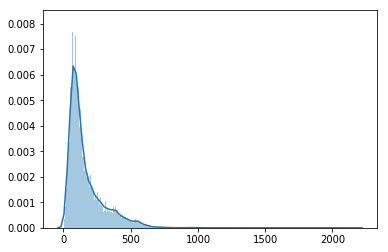

In [24]:
import seaborn as sns
sns.distplot(num_words, bins=500)
plt.show()

In [25]:
# prepare tokenizer
t = Tokenizer()
t.fit_on_texts(docs)
vocab_size = len(t.word_index) + 1
# integer encode the documents
encoded_docs = t.texts_to_sequences(docs)
# pad documents to a max length of 250 words 
max_length = 250
# using Keras's built in pad_sequences 
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')


In [26]:
embedding_matrix = np.zeros((vocab_size, 100))

absent_words = 0

for word, i in t.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        absent_words += 1
        
print('Total absent words are', absent_words, 'which is', "%0.2f" % (absent_words * 100 / len(t.word_index)), '% of total words')

Total absent words are 0 which is 0.00 % of total words


In [27]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(padded_docs, y, test_size = 0.2, random_state = 0, stratify = y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((50252, 250), (12563, 250), (50252, 7), (12563, 7))

In [42]:
from keras.layers import LSTM, Activation, Dropout, Dense, Input, Bidirectional, RepeatVector, Permute, Multiply, Lambda
from keras.models import Model
from keras import backend as K 

"""
keras.layers.Permute(dims)
Permutes the dimensions of the input according to a given pattern.

Example
-------

model.add(Permute((2, 1), input_shape=(10, 64)))
# now: model.output_shape == (None, 64, 10)
# note: `None` is the batch dimension

"""

import os
from keras.optimizers import Adam


# Reference
# ---------
# https://www.youtube.com/watch?v=oaV_Fv5DwUM&t=7s

#model = Sequential()
word_dim = 100 

seq_input = Input(shape = (max_length, ), dtype = 'int32')
e = Embedding(vocab_size, word_dim, weights=[embedding_matrix], input_length=250, trainable=False)(seq_input)
activations = Bidirectional(LSTM(764, return_sequences = True))(e)


## --- Attention Mecchanism -----
word_att, att_weight = AttentionWithContext()(activations)
## --- Attention Mecchanism -----

word_dense = Dense(len(y[0]), activation = 'softmax')(word_att)

model = Model(inputs = seq_input, outputs = word_dense)

#adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False, clipnorm=1.)

model.compile(loss='categorical_crossentropy', optimizer="sgd" , metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        (None, 250)               0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 250, 100)          3960700   
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 250, 1528)         5286880   
_________________________________________________________________
attention_with_context_10 (A [(None, 1528), (None, 250 2337840   
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 10703     
Total params: 11,596,123
Trainable params: 7,635,423
Non-trainable params: 3,960,700
_________________________________________________________________


In [43]:
from keras.callbacks import EarlyStopping

es = EarlyStopping(monitor='val_loss', mode='min', patience = 5, verbose=1)

In [44]:
hist = model.fit(X_train, y_train, validation_data =(X_test, y_test), epochs=50, verbose=1, callbacks = [es])


Train on 50252 samples, validate on 12563 samples
Epoch 1/50
50252/50252 [==============================] - 860s 17ms/step - loss: 0.5302 - acc: 0.8451 - val_loss: 0.3870 - val_acc: 0.8911
Epoch 2/50
50252/50252 [==============================] - 859s 17ms/step - loss: 0.3458 - acc: 0.9024 - val_loss: 0.3054 - val_acc: 0.9096
Epoch 3/50
50252/50252 [==============================] - 856s 17ms/step - loss: 0.2778 - acc: 0.9136 - val_loss: 0.2547 - val_acc: 0.9156
Epoch 4/50
50252/50252 [==============================] - 857s 17ms/step - loss: 0.2385 - acc: 0.9228 - val_loss: 0.2219 - val_acc: 0.9274
Epoch 5/50
50252/50252 [==============================] - 856s 17ms/step - loss: 0.2184 - acc: 0.9269 - val_loss: 0.2222 - val_acc: 0.9229
Epoch 6/50
50252/50252 [==============================] - 849s 17ms/step - loss: 0.2035 - acc: 0.9323 - val_loss: 0.1917 - val_acc: 0.9366
Epoch 7/50
50252/50252 [==============================] - 847s 17ms/step - loss: 0.1930 - acc: 0.9349 - val_loss: 0.

KeyboardInterrupt: 

In [46]:
from sklearn.metrics import f1_score, classification_report
y_pred = model.predict(X_test)

In [50]:
y_pred_int = np.argmax(y_pred, axis = 1)

In [51]:
y_test_int =np.argmax(y_test, axis=1)

f1_score(y_test_int, y_pred_int, average = 'micro')

0.9660113030327151

In [53]:
target_name = ['ADULT', 'COUNTERFEIT', 'LEGIT', 'PHARMA', 'SMOKE', 'TMS', 'WEAPON']
print(classification_report(y_test_int, y_pred_int, target_names=target_name))

              precision    recall  f1-score   support

       ADULT       0.83      0.86      0.84       126
 COUNTERFEIT       0.88      0.83      0.86       296
       LEGIT       0.98      0.98      0.98     10186
      PHARMA       0.91      0.92      0.92      1712
       SMOKE       0.72      0.81      0.76        47
         TMS       0.84      0.70      0.76        23
      WEAPON       0.94      0.97      0.95       173

    accuracy                           0.97     12563
   macro avg       0.87      0.87      0.87     12563
weighted avg       0.97      0.97      0.97     12563



In [54]:
model.save('glove_50_biLSTM_attention_all_raw.h5')

In [ ]:
#from keras.models import load_model
#model = load_model('glove_50_biLSTM_attention_all_raw.h5')


In [61]:
import time 

test = padded_docs[11015].reshape(1, -1)
test.shape

start = time.time()
model.predict(test)
end = time.time()

print("Time taken for 1 prediction: {} seconds".format(round(end - start, 3)))

Time taken for 1 prediction: 0.181 seconds


## Attention Explainability  

https://github.com/tsterbak/keras_attention/blob/master/models.py

In [62]:
def _get_attention_map(model, texts):
    att_model_output = model.layers[0:-1]
    att_model = Model(att_model_output[0].input, att_model_output[-1].output)
    
    att_model.compile(loss='categorical_crossentropy', optimizer="sgd" , metrics=['accuracy'])

    return att_model.predict(texts)[1]

In [64]:
# _y_pred = model.predict(X_test)
y_attn = _get_attention_map(model, X_test)

In [65]:
y_attn[0].shape

(250, 1)

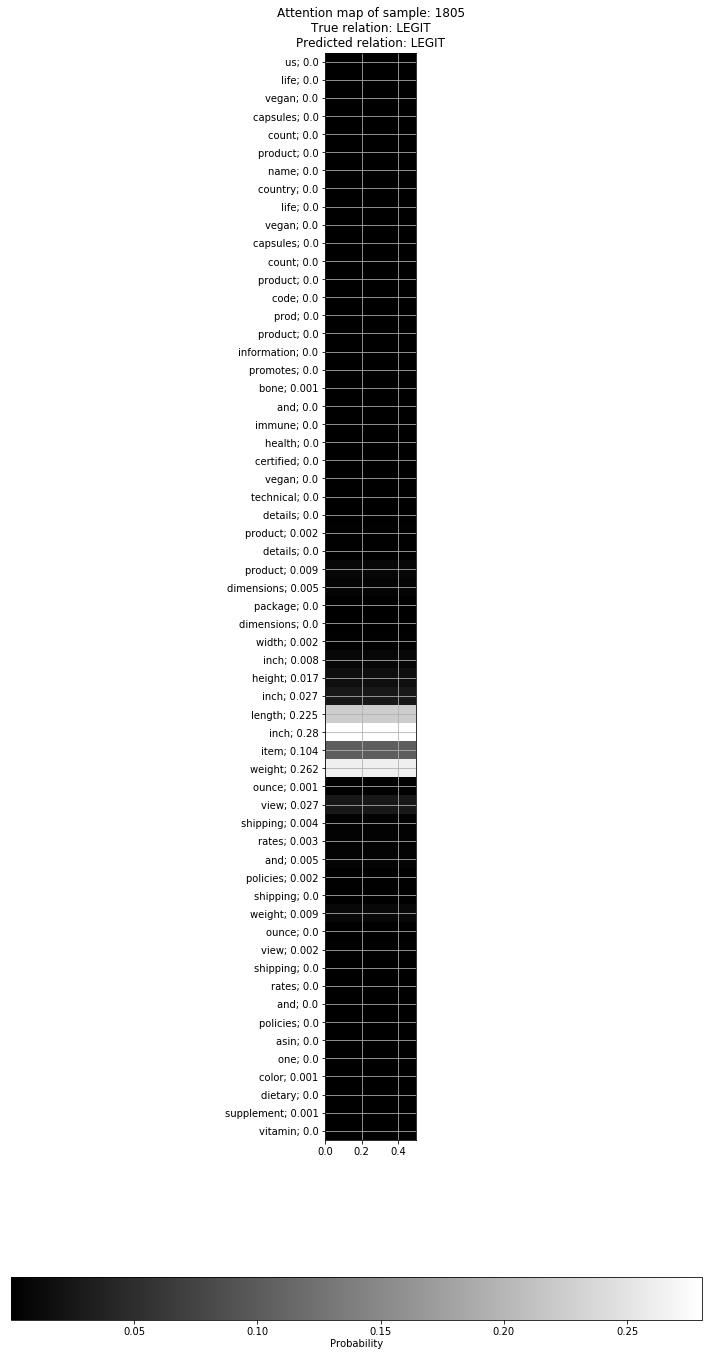

In [98]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}


vis_sample = 0 # change this to visualize different samples 


text = t.sequences_to_texts(X_test[vis_sample].reshape(1, -1))

activation_map = y_attn[vis_sample][:len(text[0].split())]
f = plt.figure(figsize=(16, 20))
ax = f.add_subplot(1, 1, 1)

img = ax.imshow(activation_map, interpolation='none', cmap='gray')

a = activation_map.flatten()
display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

plt.xlim([0,0.5])
ax.set_aspect(0.1)
ax.set_yticks(range(len(text[0].split())))
ax.set_yticklabels(display_texts)
ax.grid()
plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
          .format(i, cat_dict[y_test_int[i]], cat_dict[y_pred_int[i]]));

# add colorbar
cbaxes = f.add_axes([0.2, 0, 0.6, 0.03]);
cbar = f.colorbar(img, cax=cbaxes, orientation='horizontal');
cbar.ax.set_xlabel('Probability', labelpad=2);

# black ==> probability = 0 


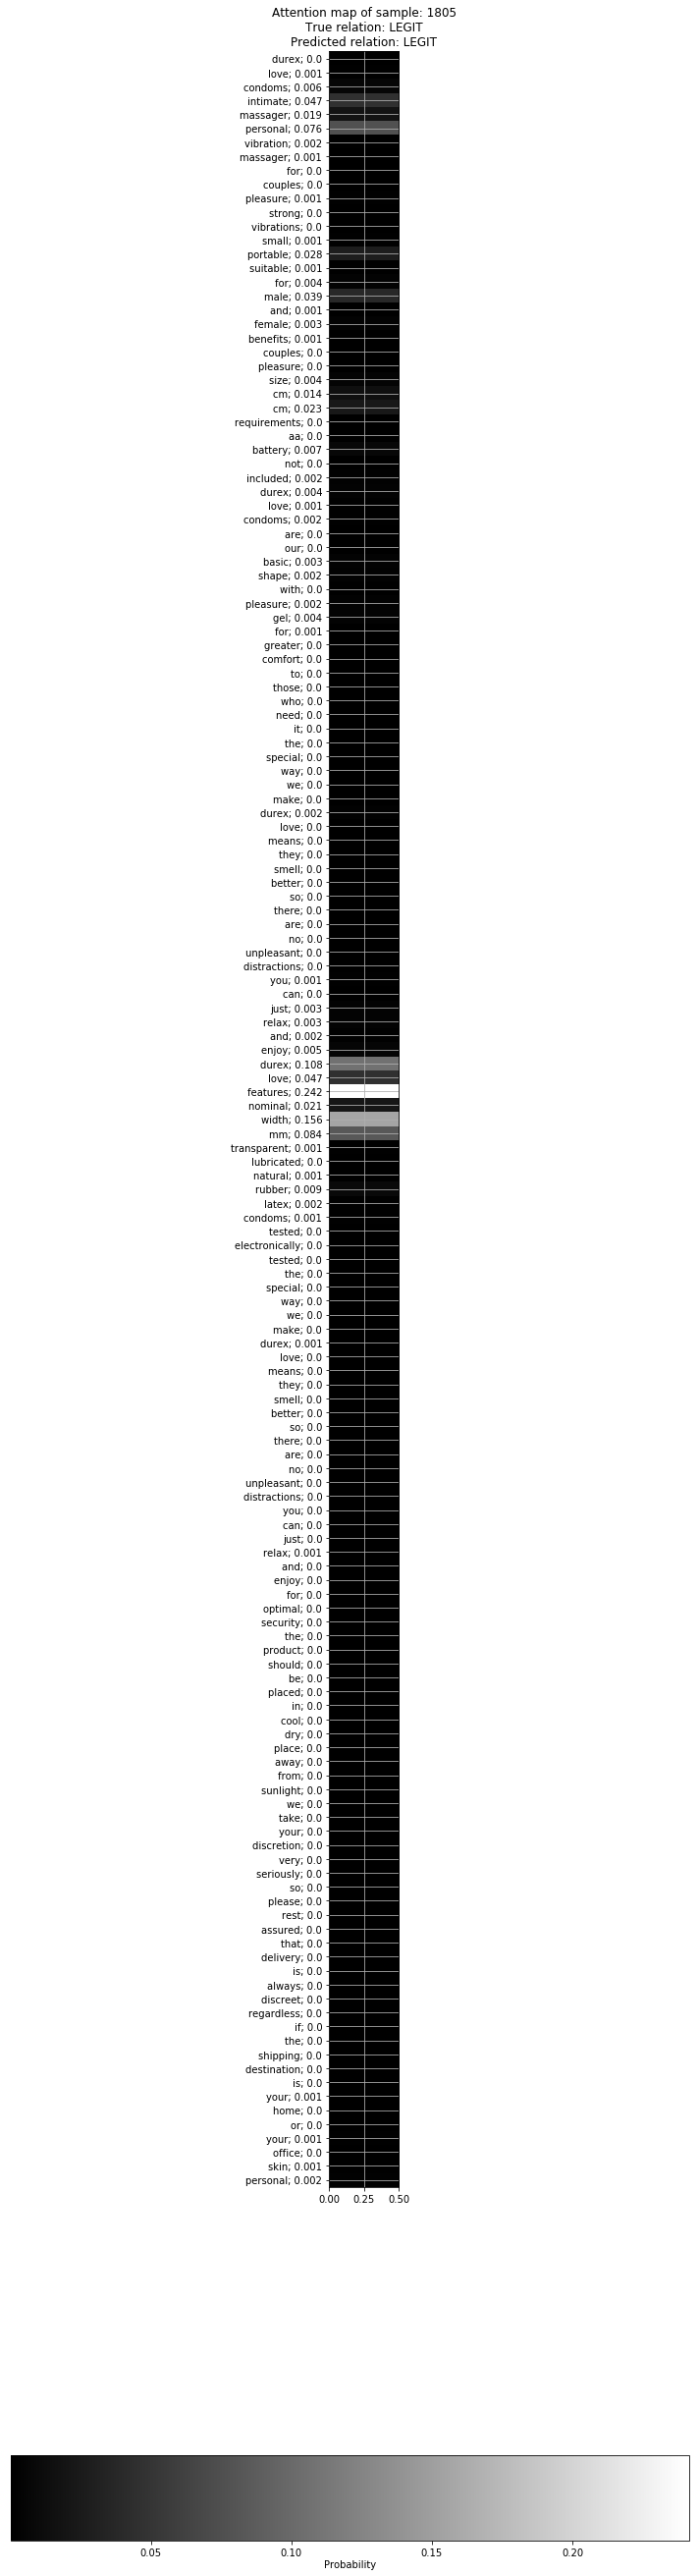

In [100]:
vis_sample = 3 # change this to visualize different samples 


text = t.sequences_to_texts(X_test[vis_sample].reshape(1, -1))

activation_map = y_attn[vis_sample][:len(text[0].split())]
f = plt.figure(figsize=(16, 40))
ax = f.add_subplot(1, 1, 1)

img = ax.imshow(activation_map, interpolation='none', cmap='gray')

a = activation_map.flatten()
display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

plt.xlim([0,0.5])
ax.set_aspect(0.1)
ax.set_yticks(range(len(text[0].split())))
ax.set_yticklabels(display_texts)
ax.grid()
plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
          .format(i, cat_dict[y_test_int[i]], cat_dict[y_pred_int[i]]));

# add colorbar
cbaxes = f.add_axes([0.2, 0, 0.6, 0.03]);
cbar = f.colorbar(img, cax=cbaxes, orientation='horizontal');
cbar.ax.set_xlabel('Probability', labelpad=2);

# black ==> probability = 0 

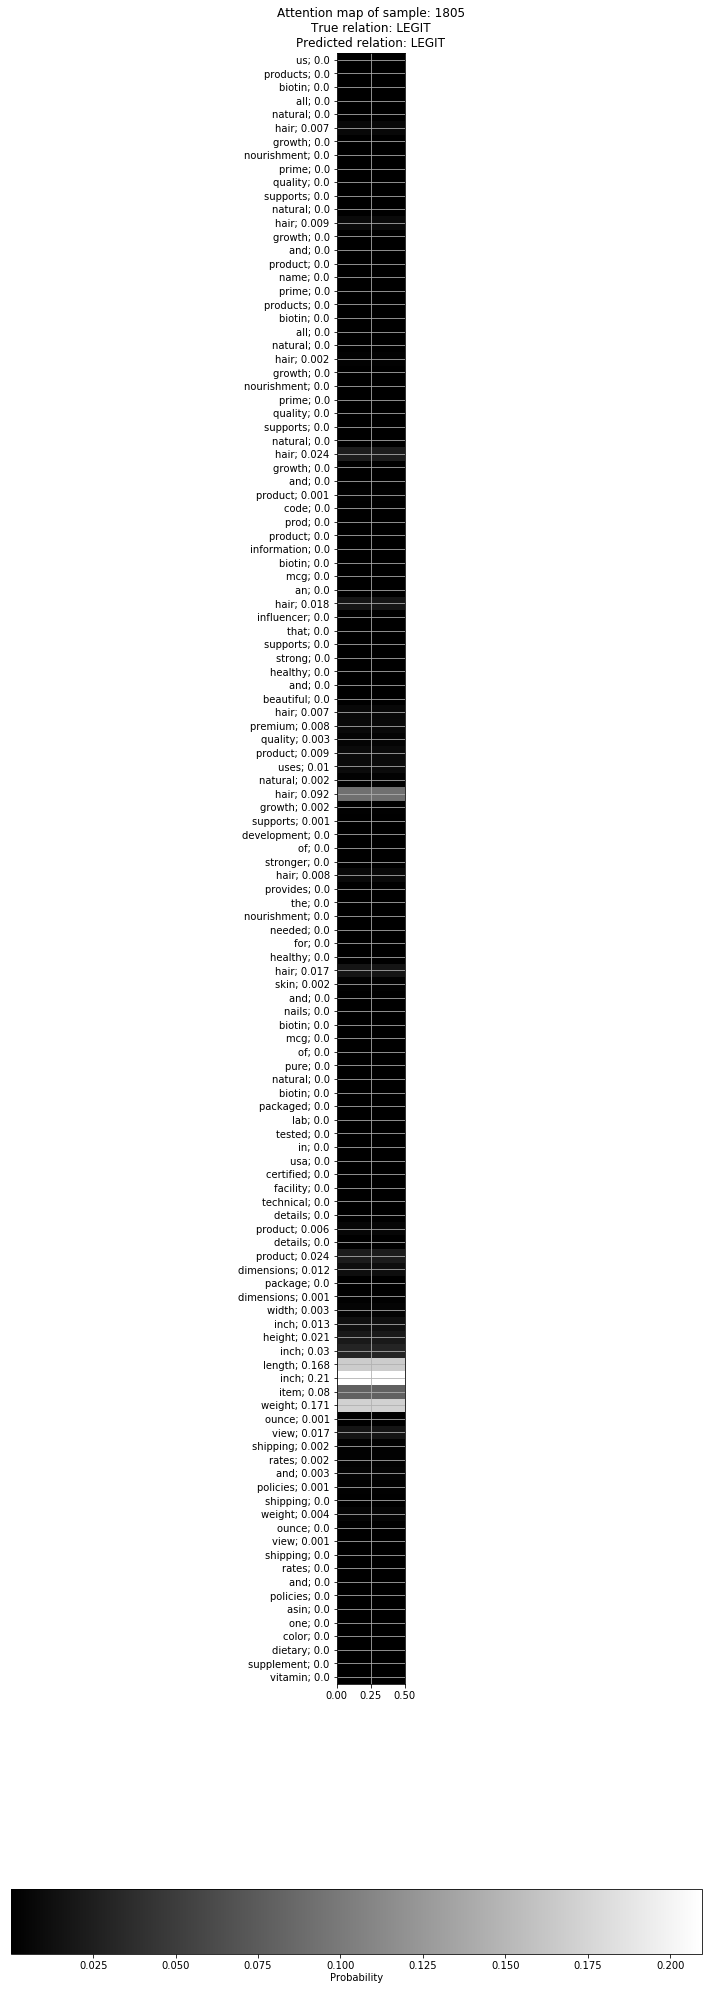

In [102]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}


vis_sample = 100 # change this to visualize different samples 


text = t.sequences_to_texts(X_test[vis_sample].reshape(1, -1))

activation_map = y_attn[vis_sample][:len(text[0].split())]
f = plt.figure(figsize=(16, 30))
ax = f.add_subplot(1, 1, 1)

img = ax.imshow(activation_map, interpolation='none', cmap='gray')

a = activation_map.flatten()
display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

plt.xlim([0,0.5])
ax.set_aspect(0.1)
ax.set_yticks(range(len(text[0].split())))
ax.set_yticklabels(display_texts)
ax.grid()
plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
          .format(i, cat_dict[y_test_int[i]], cat_dict[y_pred_int[i]]));

# add colorbar
cbaxes = f.add_axes([0.2, 0, 0.6, 0.03]);
cbar = f.colorbar(img, cax=cbaxes, orientation='horizontal');
cbar.ax.set_xlabel('Probability', labelpad=2);

# black ==> probability = 0 


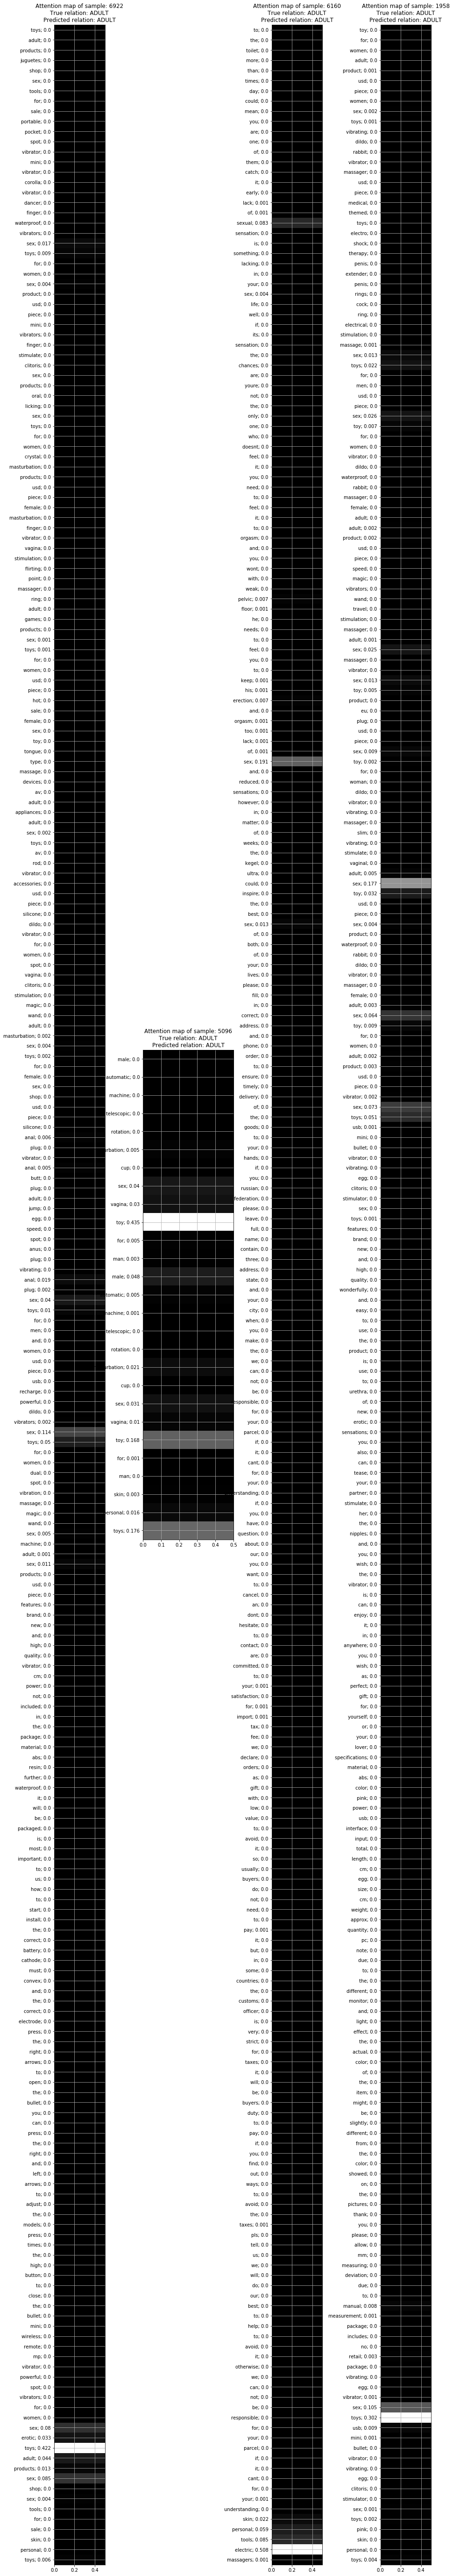

In [138]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}

f = plt.figure(figsize=(16, 100))
k = 1 


# vis_sample = [101, 102, 103, 104, 200, 201, 202, 203] # change this to visualize different samples 

# 0 : ADULT 
vis_sample = random.sample(list(np.where(y_pred_int == 0 )[0]), k = 4)

for val in vis_sample:
    
    ax = f.add_subplot(1, 4, k)

    text = t.sequences_to_texts(X_test[val].reshape(1, -1))

    activation_map = y_attn[val][:len(text[0].split())]

    img = ax.imshow(activation_map, interpolation='none', cmap='gray')

    a = activation_map.flatten()
    display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

    plt.xlim([0,0.5])
    ax.set_aspect(0.1)
    ax.set_yticks(range(len(text[0].split())))
    ax.set_yticklabels(display_texts)
    ax.grid()
    plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
              .format(val, cat_dict[y_test_int[val]], cat_dict[y_pred_int[val]]));
    k += 1 


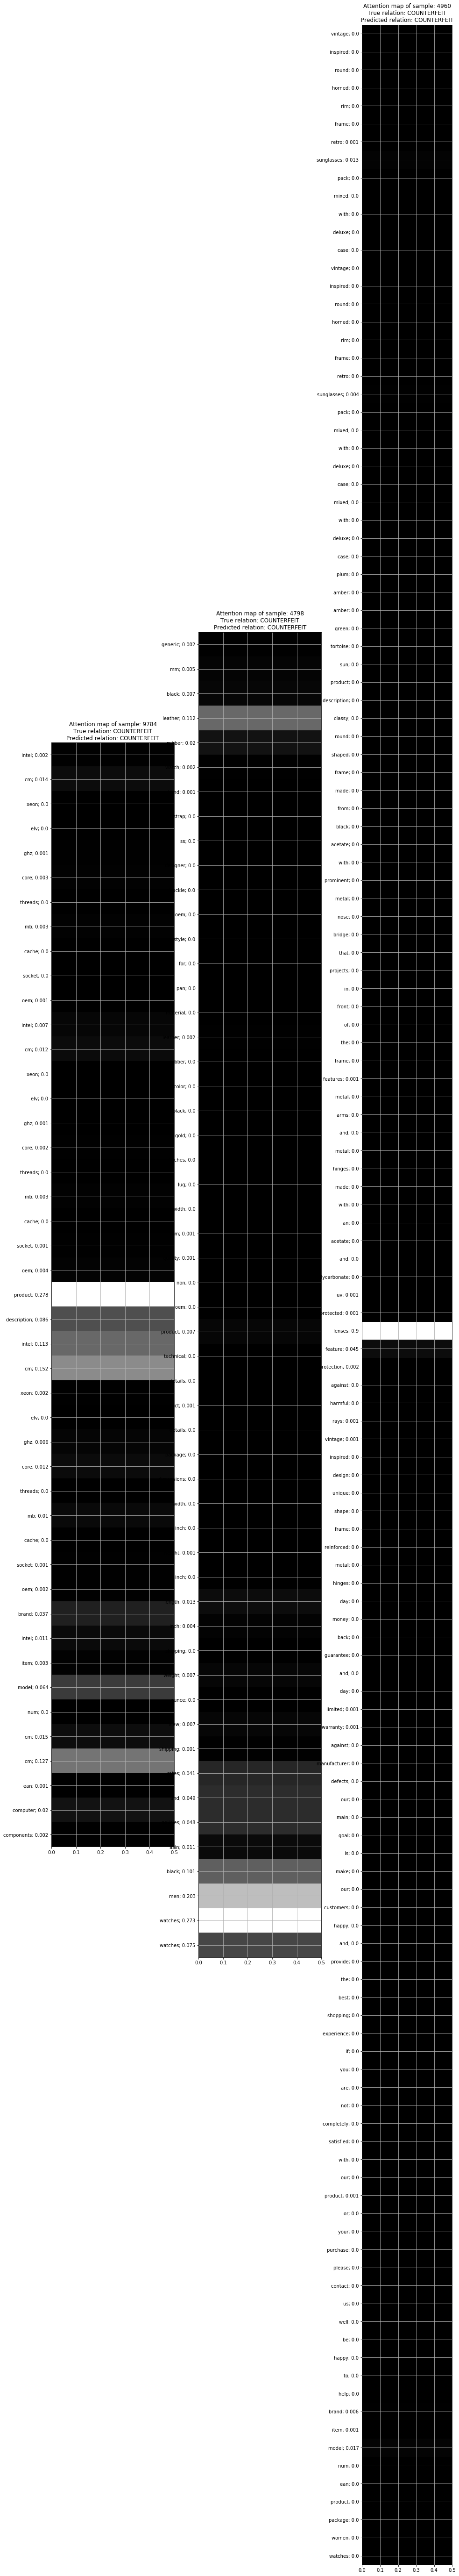

In [141]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}

f = plt.figure(figsize=(16, 100))
k = 1 


# vis_sample = [101, 102, 103, 104, 200, 201, 202, 203] # change this to visualize different samples 

vis_sample = random.sample(list(np.where(y_pred_int == 1 )[0]), k = 3)

for val in vis_sample:
    
    ax = f.add_subplot(1, 3, k)

    text = t.sequences_to_texts(X_test[val].reshape(1, -1))

    activation_map = y_attn[val][:len(text[0].split())]

    img = ax.imshow(activation_map, interpolation='none', cmap='gray')

    a = activation_map.flatten()
    display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

    plt.xlim([0,0.5])
    ax.set_aspect(0.1)
    ax.set_yticks(range(len(text[0].split())))
    ax.set_yticklabels(display_texts)
    ax.grid()
    plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
              .format(val, cat_dict[y_test_int[val]], cat_dict[y_pred_int[val]]));
    k += 1 


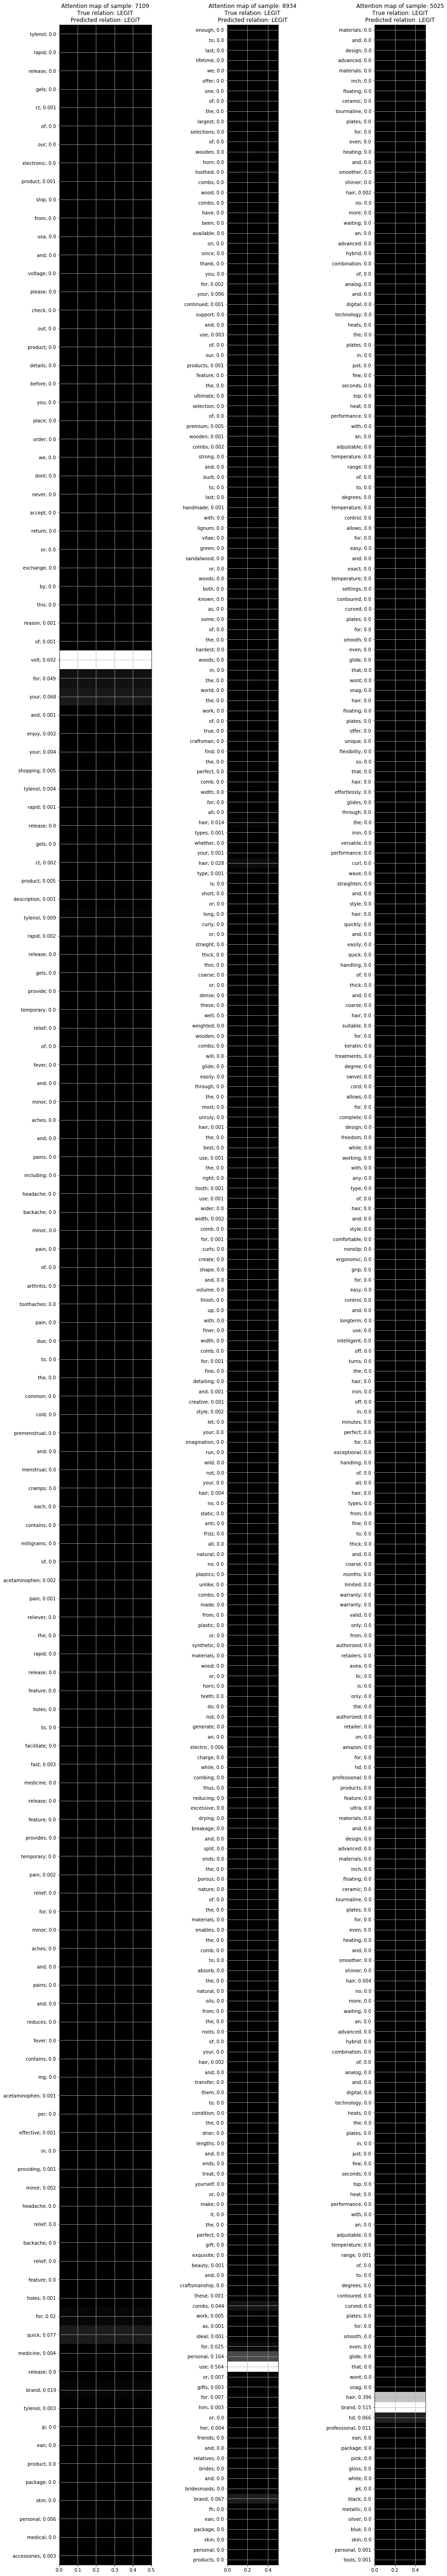

In [142]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}

f = plt.figure(figsize=(16, 100))
k = 1 


# vis_sample = [101, 102, 103, 104, 200, 201, 202, 203] # change this to visualize different samples 

vis_sample = random.sample(list(np.where(y_pred_int == 2 )[0]), k = 3)

for val in vis_sample:
    
    ax = f.add_subplot(1, 3, k)

    text = t.sequences_to_texts(X_test[val].reshape(1, -1))

    activation_map = y_attn[val][:len(text[0].split())]

    img = ax.imshow(activation_map, interpolation='none', cmap='gray')

    a = activation_map.flatten()
    display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

    plt.xlim([0,0.5])
    ax.set_aspect(0.1)
    ax.set_yticks(range(len(text[0].split())))
    ax.set_yticklabels(display_texts)
    ax.grid()
    plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
              .format(val, cat_dict[y_test_int[val]], cat_dict[y_pred_int[val]]));
    k += 1 


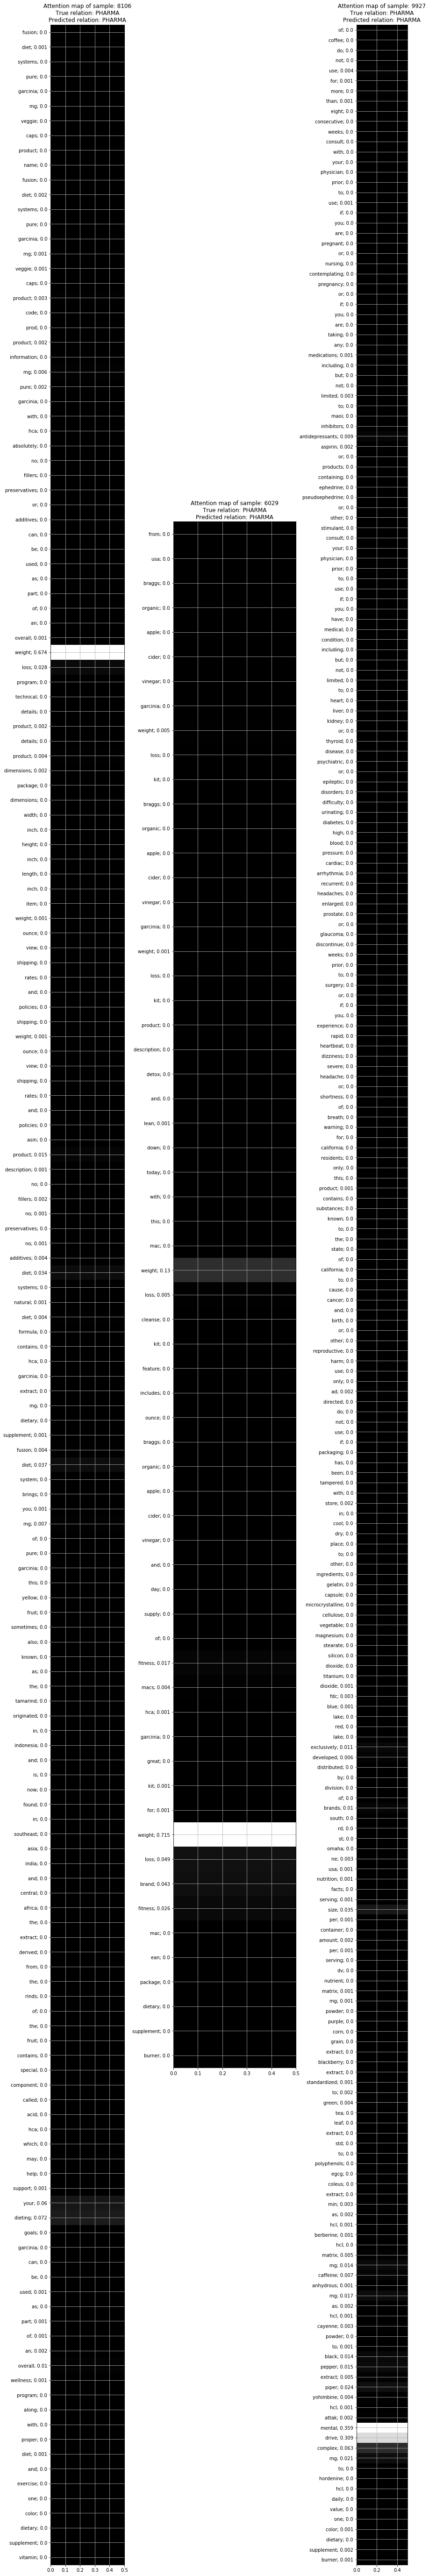

In [143]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}

f = plt.figure(figsize=(16, 100))
k = 1 


# vis_sample = [101, 102, 103, 104, 200, 201, 202, 203] # change this to visualize different samples 

vis_sample = random.sample(list(np.where(y_pred_int == 3 )[0]), k = 3)

for val in vis_sample:
    
    ax = f.add_subplot(1, 3, k)

    text = t.sequences_to_texts(X_test[val].reshape(1, -1))

    activation_map = y_attn[val][:len(text[0].split())]

    img = ax.imshow(activation_map, interpolation='none', cmap='gray')

    a = activation_map.flatten()
    display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

    plt.xlim([0,0.5])
    ax.set_aspect(0.1)
    ax.set_yticks(range(len(text[0].split())))
    ax.set_yticklabels(display_texts)
    ax.grid()
    plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
              .format(val, cat_dict[y_test_int[val]], cat_dict[y_pred_int[val]]));
    k += 1 


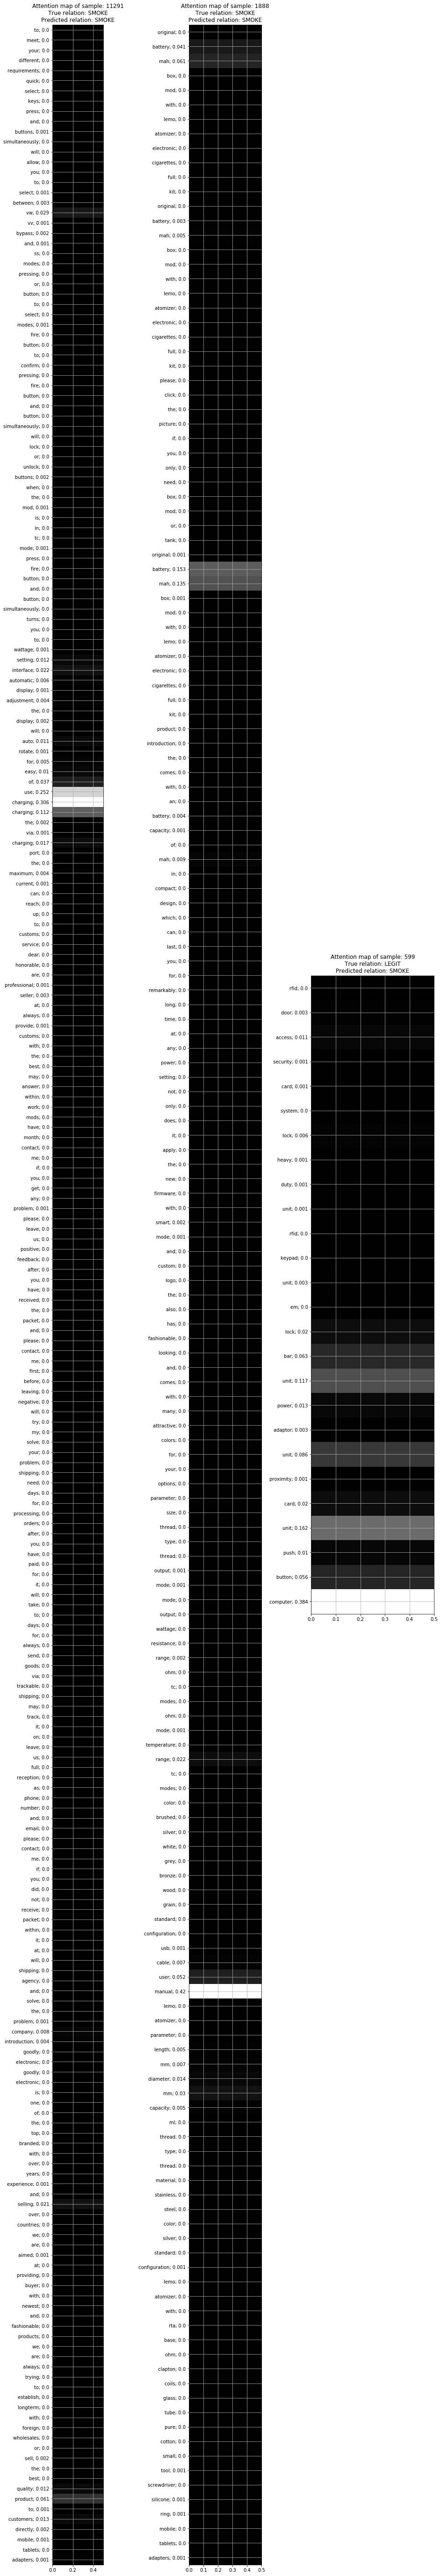

In [144]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}

f = plt.figure(figsize=(16, 100))
k = 1 


# vis_sample = [101, 102, 103, 104, 200, 201, 202, 203] # change this to visualize different samples 

vis_sample = random.sample(list(np.where(y_pred_int == 4 )[0]), k = 3)

for val in vis_sample:
    
    ax = f.add_subplot(1, 3, k)

    text = t.sequences_to_texts(X_test[val].reshape(1, -1))

    activation_map = y_attn[val][:len(text[0].split())]

    img = ax.imshow(activation_map, interpolation='none', cmap='gray')

    a = activation_map.flatten()
    display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

    plt.xlim([0,0.5])
    ax.set_aspect(0.1)
    ax.set_yticks(range(len(text[0].split())))
    ax.set_yticklabels(display_texts)
    ax.grid()
    plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
              .format(val, cat_dict[y_test_int[val]], cat_dict[y_pred_int[val]]));
    k += 1 


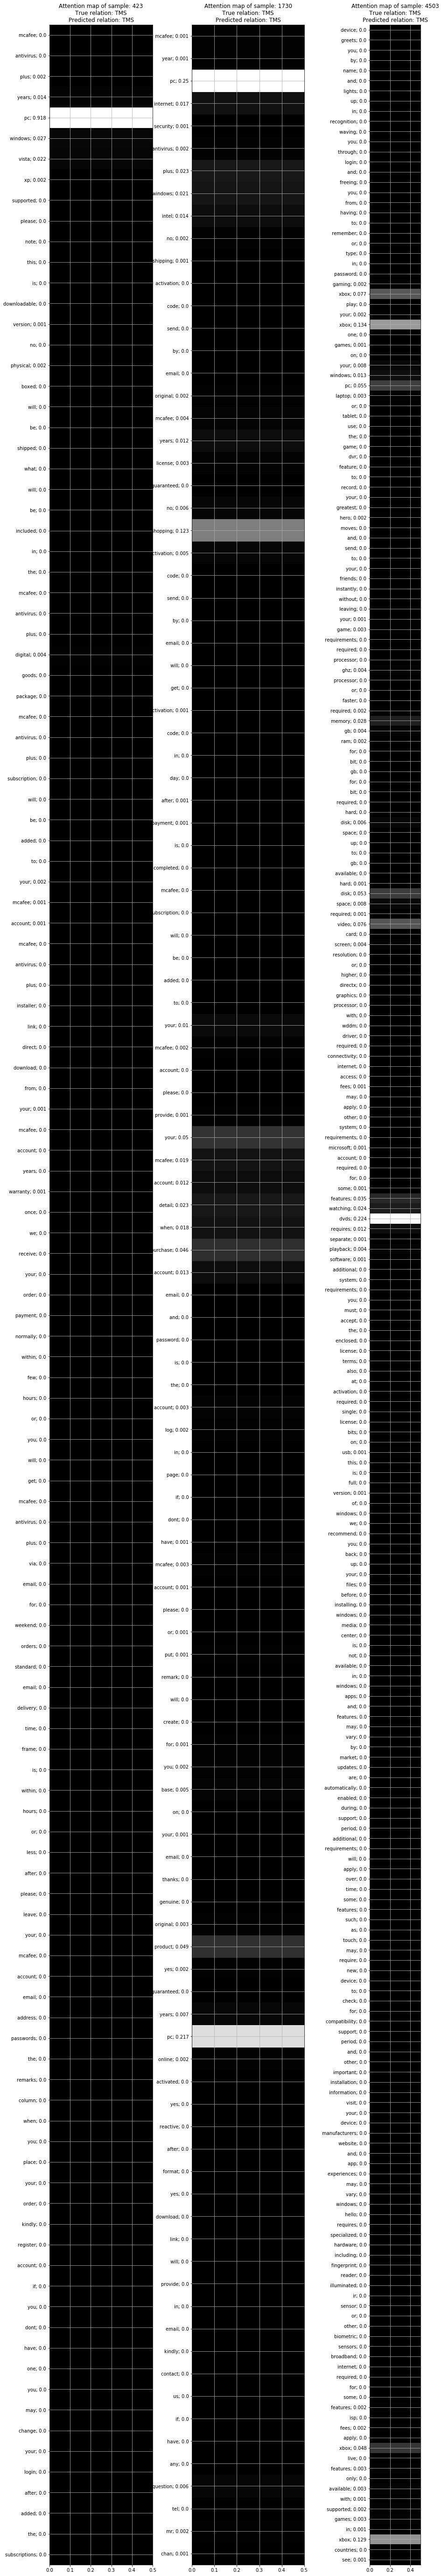

In [145]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}

f = plt.figure(figsize=(16, 100))
k = 1 


# vis_sample = [101, 102, 103, 104, 200, 201, 202, 203] # change this to visualize different samples 

vis_sample = random.sample(list(np.where(y_pred_int == 5 )[0]), k = 3)

for val in vis_sample:
    
    ax = f.add_subplot(1, 3, k)

    text = t.sequences_to_texts(X_test[val].reshape(1, -1))

    activation_map = y_attn[val][:len(text[0].split())]

    img = ax.imshow(activation_map, interpolation='none', cmap='gray')

    a = activation_map.flatten()
    display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

    plt.xlim([0,0.5])
    ax.set_aspect(0.1)
    ax.set_yticks(range(len(text[0].split())))
    ax.set_yticklabels(display_texts)
    ax.grid()
    plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
              .format(val, cat_dict[y_test_int[val]], cat_dict[y_pred_int[val]]));
    k += 1 


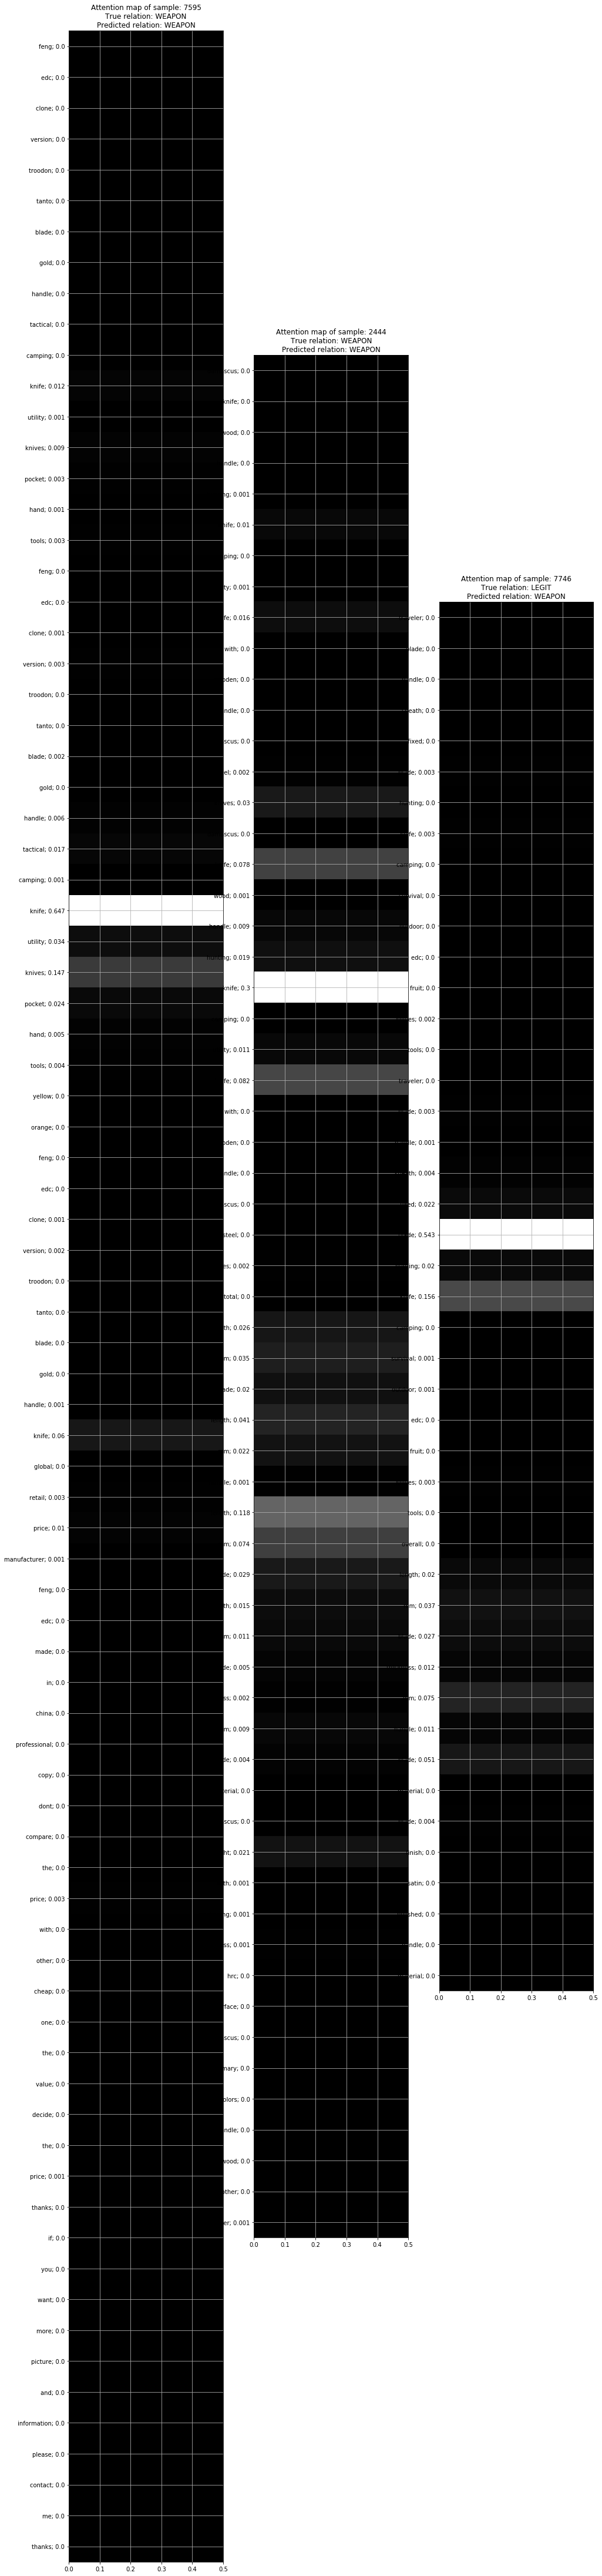

In [146]:
cat_dict = {0:'ADULT', 1:'COUNTERFEIT', 2:'LEGIT', 3:'PHARMA', 4:'SMOKE', 5:'TMS', 6:'WEAPON'}

f = plt.figure(figsize=(16, 100))
k = 1 


# vis_sample = [101, 102, 103, 104, 200, 201, 202, 203] # change this to visualize different samples 

vis_sample = random.sample(list(np.where(y_pred_int == 6 )[0]), k = 3)

for val in vis_sample:
    
    ax = f.add_subplot(1, 3, k)

    text = t.sequences_to_texts(X_test[val].reshape(1, -1))

    activation_map = y_attn[val][:len(text[0].split())]

    img = ax.imshow(activation_map, interpolation='none', cmap='gray')

    a = activation_map.flatten()
    display_texts = [text[0].split()[i] + "; " + str(round(a[i], 3)) for i in range(len(a))] # text[0].split()

    plt.xlim([0,0.5])
    ax.set_aspect(0.1)
    ax.set_yticks(range(len(text[0].split())))
    ax.set_yticklabels(display_texts)
    ax.grid()
    plt.title("Attention map of sample: {}\nTrue relation: {}\nPredicted relation: {}"
              .format(val, cat_dict[y_test_int[val]], cat_dict[y_pred_int[val]]));
    k += 1 


### Visualize Misclassifications

In [ ]:
y_pred = model.predict_classes(X_test)
y_test_int =np.argmax(y_test, axis=1)

In [59]:
X_test[18]

array([12051,   239, 12051,   239,   137,  5163,  4079,     7,  8685,
        1555,   472,  7574,    27,  1408,   534,    35,  2231,  1805,
           6,   143, 12051,   239,   137,  5163,  4079,     7,  8685,
        1555,   472,  7574,    27,  1408,   534,    35,  2231,  1805,
           6,   176,   193,     6,   161,  8685,  1555,  4079,  7574,
          25,  1805,  1151,     7,   592,     4,  7574,   208,   387,
         137,    97,  1805,  1151,  5163,   131,   150,  7574,    25,
           7,  8685,  1555,   472,    16,   436,    40,    66,  2231,
         199,    57,     6,    57,     6,   113,    15,   113,   154,
          45,   165,    45,    99,    45,    46,    23,    50,   116,
          47,   121,     1,   122,    47,    23,  1250,   116,    47,
         121,     1,   122,   195,    60,    32,     8,    36,   239,
        3036,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [58]:
target_name = ['ADULT', 'COUNTERFEIT', 'LEGIT', 'PHARMA', 'SMOKE', 'TMS', 'WEAPON']

for err in np.where(y_test_int != y_pred_int)[0]:
    print("\n\n")
    print("------------------------------------------------------------------------")
    print("err index: {}".format(err))
    print("ground truth label: {}".format(target_name[y_test_int[err]]))
    print("predicted label: {}".format(target_name[y_pred_int[err]]))

    print("processed: {}".format(t.sequences_to_texts(X_test[err].reshape(1, -1))))





------------------------------------------------------------------------
err index: 18
ground truth label: LEGIT
predicted label: WEAPON
processed: ['smp medical smp medical ml syringe sterile with luer lock tip syringes by science purchase no needle individually product name smp medical ml syringe sterile with luer lock tip syringes by science purchase no needle individually product code prod product information luer lock sterile syringes are individually sealed with total of syringes per box ml size individually sealed syringe only these syringes are with luer lock tip it does not have needle technical details product details product dimensions package dimensions width inch height inch length inch item weight ounce view shipping rates and policies shipping weight pounds view shipping rates and policies asin one color skin personal medical monitors']



------------------------------------------------------------------------
err index: 107
ground truth label: LEGIT
predicted label:

------------------------------------------------------------------------
err index: 7235
ground truth label: PHARMA
predicted label: LEGIT
processed: ['up to hours avoid come in contact with intense heat sources heat curlers hair dryer fires or recommend your clients to use face wash and cosmetic to avoid breaking down the bonding agent of the extensions always use wands or clean mascara wand to clean and groom lashes daily purchasing adhesive in the summer is definitely different than just normal spring fall or winter please be home for delivery so it doesnt sit outside at your doorstep in the heat and direct sun which can do damage to your glue be awesome ni important information indications badass adhesive should only be applied in areas to reduce the risk of irritation its also important that your clients eyes are fully shut during the application procedure fumes from the eyelash adhesive can escape into clients eye if not sealed off properly your clients may feel stinging burning 

## 11-street Production Data Analysis

In [147]:
path = "prod_bert_perform_eval/clean/"

In [148]:
import os
df = pd.DataFrame()
for file in os.listdir(path):
    if file.endswith('.csv'):
        temp_df = pd.read_csv(path+'{}'.format(file), index_col=0)
        print(file,temp_df.shape)
        df = df.append(temp_df)


11street_dec18_fp.csv (34924, 16)
11street_mar_fp.csv (8451, 16)
11street_jan_fp.csv (39470, 16)
11street_apr_fp.csv (6592, 16)
11street_may_fp.csv (6938, 16)
11street_feb_fp.csv (7159, 16)


In [149]:
df['combined_txt'] = df['prod_name_txt'] + df['prod_body_txt_clean'].apply(lambda x:' '+str(x))

In [150]:
df.head()

_id   prod_id  \
0  ObjectId(5c2a516d5c98c14ad874102f)  68740700   
1  ObjectId(5c2a4b015c98c14ad8740ff2)  68740493   
2  ObjectId(5c2a4aff5c98c14ad8740ff0)  68740492   
3  ObjectId(5c2a4aff5c98c14ad8740fee)  68740491   
4  ObjectId(5c2a4a625c98c14ad8740fe7)  68740490   

                                       prod_name_txt  \
0  Upgraded Powerful Vibrate Wand Massager with 2...   
1  FESTIVE DESIGN PLAZO (FULLY STITCHED)  [PRE OR...   
2  FESTIVE DESIGN PLAZO (FULLY STITCHED)  [PRE OR...   
3  FESTIVE DESIGN PLAZO (FULLY STITCHED)  [PRE OR...   
4  LENGHA FLOWER [PRE ORDER DELIVERY WITHIN 7-15 ...   

                                 prod_body_txt_clean  prod_price  \
0  Upgraded Powerful Vibrate Wand Massager with 2...         219   
1              FABRIC: PURE ORGANIC DUPATTA: MASLEEN         100   
2              FABRIC: PURE ORGANIC DUPATTA: MASLEEN         100   
3              FABRIC: PURE ORGANIC DUPATTA: MASLEEN         100   
4     FABRIC: TISHU NET HEAVY EMROIDERY DUPATTA: NET         110   

  prod_price_currency                                      prod_tags_txt  \
0                 MYR  Skin & Personal Care,Beauty Tools & Accessorie...   
1                 MYR        Women Clothing,Women Traditional Wear,Kurti   
2                 MYR        Women Clothing,Women Traditional Wear,Kurti   
3                 MYR        Women Clothing,Women Traditional Wear,Kurti   
4                 MYR        Women Clothing,Women Traditional Wear,Kurti   

                   created_datetime                 modified_datetime  \
0  2018-12-31 17:27:09.176000+00:00  2018-12-31 17:27:16.752000+00:00   
1  2018-12-31 16:59:45.772000+00:00  2018-12-31 16:59:47.085000+00:00   
2  2018-12-31 16:59:43.447000+00:00  2018-12-31 16:59:44.889000+00:00   
3  2018-12-31 16:59:43.354000+00:00  2018-12-31 16:59:44.654000+00:00   
4  2018-12-31 16:57:06.975000+00:00  2018-12-31 16:57:10.240000+00:00   

                      sent_datetime alert_category heu_reason  customer  \
0  2018-12-31 17:27:09.176000+00:00            NaN        NaN  11street   
1  2018-12-31 16:59:45.772000+00:00            NaN        NaN  11street   
2  2018-12-31 16:59:43.447000+00:00            NaN        NaN  11street   
3  2018-12-31 16:59:43.354000+00:00            NaN        NaN  11street   
4  2018-12-31 16:57:06.975000+00:00            NaN        NaN  11street   

                                              result is_false_positive  \
0  {'LEGIT': 99.99999334259536, 'SMOKE': 6.600929...               NaN   
1  {'LEGIT': 95.4775282425956, 'SMOKE': 2.9344751...               NaN   
2  {'LEGIT': 95.4775282425956, 'SMOKE': 2.9344751...               NaN   
3  {'LEGIT': 95.4775282425956, 'SMOKE': 2.9344751...               NaN   
4  {'LEGIT': 74.61083157106766, 'WEAPON': 20.8729...               NaN   

  case_status                                       combined_txt  
0         NaN  Upgraded Powerful Vibrate Wand Massager with 2...  
1         NaN  FESTIVE DESIGN PLAZO (FULLY STITCHED)  [PRE OR...  
2         NaN  FESTIVE DESIGN PLAZO (FULLY STITCHED)  [PRE OR...  
3         NaN  FESTIVE DESIGN PLAZO (FULLY STITCHED)  [PRE OR...  
4         NaN  LENGHA FLOWER [PRE ORDER DELIVERY WITHIN 7-15 ...

In [151]:
# these are the listings flagged by our naive bayes model 
df_ai = df[df['heu_reason'].isna() & df['alert_category'].notna()]

In [152]:
len(df_ai)

408

In [153]:
df_ai.head()


_id   prod_id  \
30508  ObjectId(5c1626605c98c14ad86f352a)  68639960   
31288  ObjectId(5c1236cf5c98c14ad86f0c50)  68633113   
32269  ObjectId(5c0e9aaf5c98c14ad86ee3e5)  68630414   
32297  ObjectId(5c0e770b5c98c14ad86ee26e)  68630338   
32914  ObjectId(5c0b6ad45c98c14ad86ec2dd)  68628459   

                                           prod_name_txt  \
30508                       Classic Black Cosmetic Pouch   
31288  90L Large Capacity Military Camouflage Hiking ...   
32269                                   Enai Red Chillie   
32297                 STARLO 10000MAH POWER BANK (BLACK)   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...   

                                     prod_body_txt_clean  prod_price  \
30508                            Size: 14cm x 13cm x 4cm          12   
31288  Material : Nylon Dimension : 65cm X 29cm X 25c...          99   
32269                                   Enai Red Chillie           8   
32297  Estimated Delivery 2 to 5 Days Starlo 10000mah...          80   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...          14   

      prod_price_currency                                      prod_tags_txt  \
30508                 MYR  Women Bags & Shoes,Women Bags,Clutches & Wrislets   
31288                 MYR                Men Bags & Shoes,Men Bags,Backpacks   
32269                 MYR   Cosmetics & Fragrance,Makeup,Manicure & Pedicure   
32297                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   
32914                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   

                       created_datetime                 modified_datetime  \
30508  2018-12-16 10:18:08.880000+00:00  2018-12-19 03:07:35.520000+00:00   
31288  2018-12-13 10:39:11.796000+00:00  2018-12-19 02:40:06.926000+00:00   
32269  2018-12-10 16:56:16.207000+00:00  2018-12-11 02:03:47.001000+00:00   
32297  2018-12-10 14:24:12.250000+00:00  2018-12-11 02:03:02.900000+00:00   
32914  2018-12-08 06:55:16.475000+00:00  2018-12-11 02:02:33.652000+00:00   

                          sent_datetime alert_category heu_reason  customer  \
30508  2018-12-16 10:18:08.635000+00:00         WEAPON        NaN  11street   
31288  2018-12-13 10:39:11.314000+00:00         WEAPON        NaN  11street   
32269  2018-12-10 16:56:15.391000+00:00          SMOKE        NaN  11street   
32297  2018-12-10 14:24:11.989000+00:00          SMOKE        NaN  11street   
32914  2018-12-08 06:55:16.195000+00:00          SMOKE        NaN  11street   

                                                  result is_false_positive  \
30508  {'WEAPON': 68.46901248563755, 'LEGIT': 31.1113...              True   
31288  {'WEAPON': 96.91945257932629, 'LEGIT': 3.07555...              True   
32269  {'SMOKE': 49.7039280835866, 'LEGIT': 45.964107...             False   
32297  {'SMOKE': 78.83087590209533, 'LEGIT': 21.14388...              True   
32914  {'SMOKE': 85.97757358205551, 'LEGIT': 14.02202...              True   

      case_status                                       combined_txt  
30508      Closed  Classic Black Cosmetic Pouch Size: 14cm x 13cm...  
31288      Closed  90L Large Capacity Military Camouflage Hiking ...  
32269      Closed                  Enai Red Chillie Enai Red Chillie  
32297      Closed  STARLO 10000MAH POWER BANK (BLACK) Estimated D...  
32914      Closed  AC 220V to DC 12V Power Adapter Home Cigarette...

In [154]:
# these are the false positives of our MNB model 
len(df_ai[['combined_txt', 'result', 'is_false_positive']][df_ai['is_false_positive']==True])

289

Text(0.9, 250, '70.83%')

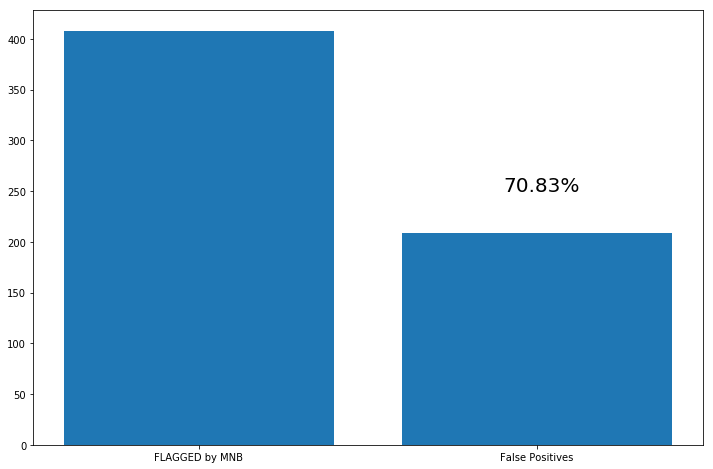

In [155]:
plt.figure(figsize = (12, 8))
plt.bar(["FLAGGED by MNB", "False Positives"], [408, 209])
plt.text(0.9, 250, str(round((289 / 408)*100, 2)) + "%" , fontsize = 20)

In [156]:
df_ai_fp = df_ai[['combined_txt', 'result', 'is_false_positive']][df_ai['is_false_positive']==True]

In [157]:
import yaml
from yaml import Loader

yaml.load(df_ai_fp['result'].values[0], Loader = Loader)

list_of_dict = list(map(lambda x: yaml.load(x, Loader = Loader), df_ai_fp['result'].values))
max_cat_score = list(map(  lambda x: (max(x.items(), key = lambda y: y[1])), list_of_dict ))


max_cat = list(map(lambda x: x[0], max_cat_score))


In [158]:
cat_dict_reverse = {'ADULT':0, 'COUNTERFEIT':1, 'LEGIT':2, 'PHARMA':3, 'SMOKE':4,'TMS':5, 'WEAPON':6}
max_cat_num = list(map(lambda x: cat_dict_reverse[x], max_cat))


In [159]:
set(max_cat_num)

{4, 5, 6}

In [165]:
encoded_Y = encoder.transform(max_cat_num)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

docs = df_ai_fp['combined_txt'].values



for i, d in enumerate(docs):
    
    docs[i].replace("(", " ")
    docs[i].replace(")", " ")
    docs[i].replace("[", " ")
    docs[i].replace("]", " ")
    
    # remove all non-alphanumeric characters 
    docs[i] = re.sub('[^A-Za-z\s]+', '', docs[i])
    
    
def filter_emb(sent):
    
    new_sent = [] 
    for i, word in enumerate(sent.lower().split(" ")):
        embedding_vector = embeddings_index.get(word)
        if len(word) <= 1:
            continue
        if embedding_vector is not None:
            new_sent.append(word)
            
    return " ".join(new_sent)
    
m = len(docs)
for i in range(m):
    print("{}/ {}".format(i, m))
    docs[i] = filter_emb(docs[i])
    


In [166]:
encoded_docs = t.texts_to_sequences(docs)

In [167]:
max_length = 250
# using Keras's built in pad_sequences 
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [169]:
from sklearn.metrics import f1_score, classification_report


y_pred = model.predict(padded_docs)
y_pred = np.argmax(y_pred, axis = 1)


In [170]:
sum(y_pred == 2 ) / len(y_pred)

0.629757785467128

Text(1.8, 250, '62.98%')

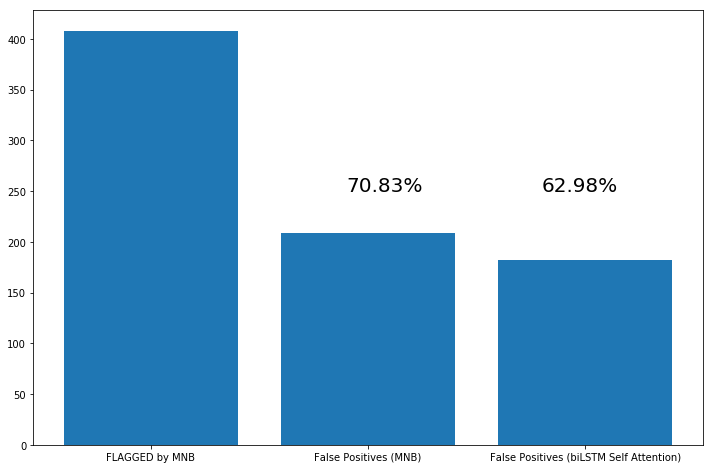

In [171]:
plt.figure(figsize = (12, 8))
plt.bar(["FLAGGED by MNB", "False Positives (MNB)", "False Positives (biLSTM Self Attention)"], [408, 209, sum(y_pred != 2)])
plt.text(0.9, 250, str(round((289 / 408)*100, 2)) + "%" , fontsize = 20)
plt.text(1.8, 250, str(round((1 -sum(y_pred == 2 ) / len(y_pred)) * 100 , 2)) + "%" , fontsize = 20)

### Simulate Production Performance 

In [172]:
df_ai = df[df['heu_reason'].isna() & df['alert_category'].notna()]

import yaml
from yaml import Loader

yaml.load(df_ai['result'].values[0], Loader = Loader)

list_of_dict = list(map(lambda x: yaml.load(x, Loader = Loader), df_ai['result'].values))
max_cat_score = list(map(  lambda x: (max(x.items(), key = lambda y: y[1])), list_of_dict ))


max_cat = list(map(lambda x: x[0], max_cat_score))

cat_dict_reverse = {'ADULT':0, 'COUNTERFEIT':1, 'LEGIT':2, 'PHARMA':3, 'SMOKE':4,'TMS':5, 'WEAPON':6}
max_cat_num = list(map(lambda x: cat_dict_reverse[x], max_cat))

encoded_Y = encoder.transform(max_cat_num)
# convert integers to dummy variables (i.e. one hot encoded)
y = np_utils.to_categorical(encoded_Y)

docs = df_ai['combined_txt'].values

encoded_docs = t.texts_to_sequences(docs)
max_length = 250
# using Keras's built in pad_sequences 
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')

In [173]:
y_pred = model.predict(padded_docs)
y_pred

array([[1.05795255e-02, 1.12164104e-02, 9.51361239e-01, ...,
        1.93618354e-03, 6.72419032e-04, 2.19570403e-03],
       [5.44986688e-02, 3.35073583e-02, 6.85931444e-01, ...,
        3.93588506e-02, 8.55481345e-03, 1.49241045e-01],
       [3.08315810e-02, 1.04720712e-01, 1.10112555e-01, ...,
        6.73109353e-01, 3.30099873e-02, 4.37869355e-02],
       ...,
       [1.68445911e-02, 5.24930917e-02, 6.71447635e-01, ...,
        2.11544503e-02, 8.48766603e-03, 5.90759777e-02],
       [5.00661973e-03, 4.93871391e-01, 4.24643338e-01, ...,
        8.50008335e-03, 2.21007154e-03, 3.47090848e-02],
       [1.50644248e-02, 1.64699078e-01, 5.26086032e-01, ...,
        1.69974342e-01, 7.28929415e-04, 1.23409584e-01]], dtype=float32)

In [174]:
y_pred.shape, np.array(max_cat).reshape(-1, 1).shape

((408, 7), (408, 1))

In [175]:
np.concatenate((np.array(max_cat).reshape(-1, 1), y_pred), axis = 1).shape

(408, 8)

In [176]:
label = np.argmax(y_pred, axis = 1)


In [177]:
# res = pd.DataFrame(np.concatenate((np.array(max_cat).reshape(-1, 1), y_pred), axis = 1), columns = ['prod_res_cat', 'ADULT' ,'COUNTERFEIT', 'LEGIT', 'PHARMA', 'SMOKE', 'TMS', 'WEAPON'])

res = pd.DataFrame(y_pred, columns = ['ADULT' ,'COUNTERFEIT', 'LEGIT', 'PHARMA', 'SMOKE', 'TMS', 'WEAPON'])

res.head()

ADULT  COUNTERFEIT     LEGIT    PHARMA     SMOKE       TMS    WEAPON
0  0.010580     0.011216  0.951361  0.022039  0.001936  0.000672  0.002196
1  0.054499     0.033507  0.685931  0.028908  0.039359  0.008555  0.149241
2  0.030832     0.104721  0.110113  0.004429  0.673109  0.033010  0.043787
3  0.033167     0.121910  0.388480  0.031148  0.290154  0.119060  0.016081
4  0.000099     0.082056  0.913839  0.000201  0.003537  0.000089  0.000179

In [178]:
res.dtypes

ADULT          float32
COUNTERFEIT    float32
LEGIT          float32
PHARMA         float32
SMOKE          float32
TMS            float32
WEAPON         float32
dtype: object

In [179]:
res['LEGIT_modified'] = res['LEGIT'].values + res['PHARMA'].values + res['ADULT'].values + res['COUNTERFEIT'].values


In [180]:
res.head()

ADULT  COUNTERFEIT     LEGIT    PHARMA     SMOKE       TMS    WEAPON  \
0  0.010580     0.011216  0.951361  0.022039  0.001936  0.000672  0.002196   
1  0.054499     0.033507  0.685931  0.028908  0.039359  0.008555  0.149241   
2  0.030832     0.104721  0.110113  0.004429  0.673109  0.033010  0.043787   
3  0.033167     0.121910  0.388480  0.031148  0.290154  0.119060  0.016081   
4  0.000099     0.082056  0.913839  0.000201  0.003537  0.000089  0.000179   

   LEGIT_modified  
0        0.995196  
1        0.802845  
2        0.250094  
3        0.574706  
4        0.996195

In [181]:
res['att_predicted_cat'] = res.idxmax(axis=1)

In [182]:
res['prod_res_cat'] = max_cat
res.head(10)

ADULT  COUNTERFEIT     LEGIT    PHARMA     SMOKE       TMS    WEAPON  \
0  0.010580     0.011216  0.951361  0.022039  0.001936  0.000672  0.002196   
1  0.054499     0.033507  0.685931  0.028908  0.039359  0.008555  0.149241   
2  0.030832     0.104721  0.110113  0.004429  0.673109  0.033010  0.043787   
3  0.033167     0.121910  0.388480  0.031148  0.290154  0.119060  0.016081   
4  0.000099     0.082056  0.913839  0.000201  0.003537  0.000089  0.000179   
5  0.044451     0.019552  0.056324  0.835764  0.011804  0.007931  0.024173   
6  0.039000     0.008377  0.083282  0.001708  0.721831  0.020590  0.125213   
7  0.001261     0.001896  0.995310  0.000939  0.000420  0.000110  0.000064   
8  0.036283     0.057995  0.422876  0.006094  0.450202  0.012594  0.013956   
9  0.025927     0.037830  0.282273  0.002304  0.603677  0.035487  0.012502   

   LEGIT_modified att_predicted_cat prod_res_cat  
0        0.995196    LEGIT_modified       WEAPON  
1        0.802845    LEGIT_modified       WEAPON  
2        0.250094             SMOKE        SMOKE  
3        0.574706    LEGIT_modified        SMOKE  
4        0.996195    LEGIT_modified        SMOKE  
5        0.956092    LEGIT_modified       WEAPON  
6        0.132366             SMOKE        SMOKE  
7        0.999406    LEGIT_modified        SMOKE  
8        0.523247    LEGIT_modified        SMOKE  
9        0.348335             SMOKE        SMOKE

In [183]:
#cat_dict_reverse = {'ADULT':0, 'COUNTERFEIT':1, 'LEGIT':2, 'PHARMA':3, 'SMOKE':4,'TMS':5, 'WEAPON':6}
#res['att_predicted_cat'] = res['att_predicted_cat'].map(cat_dict_reverse)
#res['prod_res_cat'] = res['prod_res_cat'].map(cat_dict_reverse)


In [184]:
df_ai['att_predicted_cat'] = res['att_predicted_cat'].tolist()
df_ai["prod_res_cat"] = res["prod_res_cat"].tolist()

df_ai.head()

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


_id   prod_id  \
30508  ObjectId(5c1626605c98c14ad86f352a)  68639960   
31288  ObjectId(5c1236cf5c98c14ad86f0c50)  68633113   
32269  ObjectId(5c0e9aaf5c98c14ad86ee3e5)  68630414   
32297  ObjectId(5c0e770b5c98c14ad86ee26e)  68630338   
32914  ObjectId(5c0b6ad45c98c14ad86ec2dd)  68628459   

                                           prod_name_txt  \
30508                       Classic Black Cosmetic Pouch   
31288  90L Large Capacity Military Camouflage Hiking ...   
32269                                   Enai Red Chillie   
32297                 STARLO 10000MAH POWER BANK (BLACK)   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...   

                                     prod_body_txt_clean  prod_price  \
30508                            Size: 14cm x 13cm x 4cm          12   
31288  Material : Nylon Dimension : 65cm X 29cm X 25c...          99   
32269                                   Enai Red Chillie           8   
32297  Estimated Delivery 2 to 5 Days Starlo 10000mah...          80   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...          14   

      prod_price_currency                                      prod_tags_txt  \
30508                 MYR  Women Bags & Shoes,Women Bags,Clutches & Wrislets   
31288                 MYR                Men Bags & Shoes,Men Bags,Backpacks   
32269                 MYR   Cosmetics & Fragrance,Makeup,Manicure & Pedicure   
32297                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   
32914                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   

                       created_datetime                 modified_datetime  \
30508  2018-12-16 10:18:08.880000+00:00  2018-12-19 03:07:35.520000+00:00   
31288  2018-12-13 10:39:11.796000+00:00  2018-12-19 02:40:06.926000+00:00   
32269  2018-12-10 16:56:16.207000+00:00  2018-12-11 02:03:47.001000+00:00   
32297  2018-12-10 14:24:12.250000+00:00  2018-12-11 02:03:02.900000+00:00   
32914  2018-12-08 06:55:16.475000+00:00  2018-12-11 02:02:33.652000+00:00   

                          sent_datetime alert_category heu_reason  customer  \
30508  2018-12-16 10:18:08.635000+00:00         WEAPON        NaN  11street   
31288  2018-12-13 10:39:11.314000+00:00         WEAPON        NaN  11street   
32269  2018-12-10 16:56:15.391000+00:00          SMOKE        NaN  11street   
32297  2018-12-10 14:24:11.989000+00:00          SMOKE        NaN  11street   
32914  2018-12-08 06:55:16.195000+00:00          SMOKE        NaN  11street   

                                                  result is_false_positive  \
30508  {'WEAPON': 68.46901248563755, 'LEGIT': 31.1113...              True   
31288  {'WEAPON': 96.91945257932629, 'LEGIT': 3.07555...              True   
32269  {'SMOKE': 49.7039280835866, 'LEGIT': 45.964107...             False   
32297  {'SMOKE': 78.83087590209533, 'LEGIT': 21.14388...              True   
32914  {'SMOKE': 85.97757358205551, 'LEGIT': 14.02202...              True   

      case_status                                       combined_txt  \
30508      Closed  Classic Black Cosmetic Pouch Size: 14cm x 13cm...   
31288      Closed  90L Large Capacity Military Camouflage Hiking ...   
32269      Closed                  Enai Red Chillie Enai Red Chillie   
32297      Closed  STARLO 10000MAH POWER BANK (BLACK) Estimated D...   
32914      Closed  AC 220V to DC 12V Power Adapter Home Cigarette...   

      att_predicted_cat prod_res_cat  
30508    LEGIT_modified       WEAPON  
31288    LEGIT_modified       WEAPON  
32269             SMOKE        SMOKE  
32297    LEGIT_modified        SMOKE  
32914    LEGIT_modified        SMOKE

In [185]:
df_ai['is_result_modified'] = df_ai['att_predicted_cat'] == 'LEGIT_modified'
df_ai['att_predicted_cat'] = df_ai['att_predicted_cat'].replace('LEGIT_modified','LEGIT')

df_ai.head()

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


_id   prod_id  \
30508  ObjectId(5c1626605c98c14ad86f352a)  68639960   
31288  ObjectId(5c1236cf5c98c14ad86f0c50)  68633113   
32269  ObjectId(5c0e9aaf5c98c14ad86ee3e5)  68630414   
32297  ObjectId(5c0e770b5c98c14ad86ee26e)  68630338   
32914  ObjectId(5c0b6ad45c98c14ad86ec2dd)  68628459   

                                           prod_name_txt  \
30508                       Classic Black Cosmetic Pouch   
31288  90L Large Capacity Military Camouflage Hiking ...   
32269                                   Enai Red Chillie   
32297                 STARLO 10000MAH POWER BANK (BLACK)   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...   

                                     prod_body_txt_clean  prod_price  \
30508                            Size: 14cm x 13cm x 4cm          12   
31288  Material : Nylon Dimension : 65cm X 29cm X 25c...          99   
32269                                   Enai Red Chillie           8   
32297  Estimated Delivery 2 to 5 Days Starlo 10000mah...          80   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...          14   

      prod_price_currency                                      prod_tags_txt  \
30508                 MYR  Women Bags & Shoes,Women Bags,Clutches & Wrislets   
31288                 MYR                Men Bags & Shoes,Men Bags,Backpacks   
32269                 MYR   Cosmetics & Fragrance,Makeup,Manicure & Pedicure   
32297                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   
32914                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   

                       created_datetime                 modified_datetime  \
30508  2018-12-16 10:18:08.880000+00:00  2018-12-19 03:07:35.520000+00:00   
31288  2018-12-13 10:39:11.796000+00:00  2018-12-19 02:40:06.926000+00:00   
32269  2018-12-10 16:56:16.207000+00:00  2018-12-11 02:03:47.001000+00:00   
32297  2018-12-10 14:24:12.250000+00:00  2018-12-11 02:03:02.900000+00:00   
32914  2018-12-08 06:55:16.475000+00:00  2018-12-11 02:02:33.652000+00:00   

                          sent_datetime alert_category heu_reason  customer  \
30508  2018-12-16 10:18:08.635000+00:00         WEAPON        NaN  11street   
31288  2018-12-13 10:39:11.314000+00:00         WEAPON        NaN  11street   
32269  2018-12-10 16:56:15.391000+00:00          SMOKE        NaN  11street   
32297  2018-12-10 14:24:11.989000+00:00          SMOKE        NaN  11street   
32914  2018-12-08 06:55:16.195000+00:00          SMOKE        NaN  11street   

                                                  result is_false_positive  \
30508  {'WEAPON': 68.46901248563755, 'LEGIT': 31.1113...              True   
31288  {'WEAPON': 96.91945257932629, 'LEGIT': 3.07555...              True   
32269  {'SMOKE': 49.7039280835866, 'LEGIT': 45.964107...             False   
32297  {'SMOKE': 78.83087590209533, 'LEGIT': 21.14388...              True   
32914  {'SMOKE': 85.97757358205551, 'LEGIT': 14.02202...              True   

      case_status                                       combined_txt  \
30508      Closed  Classic Black Cosmetic Pouch Size: 14cm x 13cm...   
31288      Closed  90L Large Capacity Military Camouflage Hiking ...   
32269      Closed                  Enai Red Chillie Enai Red Chillie   
32297      Closed  STARLO 10000MAH POWER BANK (BLACK) Estimated D...   
32914      Closed  AC 220V to DC 12V Power Adapter Home Cigarette...   

      att_predicted_cat prod_res_cat  is_result_modified  
30508             LEGIT       WEAPON                True  
31288             LEGIT       WEAPON                True  
32269             SMOKE        SMOKE               False  
32297             LEGIT        SMOKE                True  
32914             LEGIT        SMOKE                True

In [186]:
df_ai['att_predicted_cat'].unique()

array(['LEGIT', 'SMOKE', 'WEAPON', 'TMS'], dtype=object)

In [187]:
df_ai['is_false_positive'].unique()

array([True, False], dtype=object)

In [188]:
df_ai['case_status'].unique()

array(['Closed'], dtype=object)

In [189]:

df_ai.groupby(
    ['prod_res_cat','att_predicted_cat']).agg(
    {
        '_id': 'count',
        'is_false_positive': lambda val: (val == True).sum(),
        #'case_status': lambda val: (val == 'Closed').sum()
        'is_result_modified': lambda val: (val == True).sum(),
    })

is_result_modified  _id  is_false_positive
prod_res_cat att_predicted_cat                                            
SMOKE        LEGIT                             108  108                 86
             SMOKE                               0   10                  9
             WEAPON                              0    1                  1
TMS          LEGIT                             194  194                125
             SMOKE                               0   10                  7
             TMS                                 0    8                  7
             WEAPON                              0    1                  1
WEAPON       LEGIT                              57   57                 44
             SMOKE                               0   11                  8
             WEAPON                              0    8                  1

In [190]:
df_ai['true_class'] = df_ai.apply(lambda row: 
            'LEGIT' if row['prod_res_cat']!='LEGIT' and row['is_false_positive'] == True else 
            row['prod_res_cat'],axis=1
           )

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [191]:
df_ai['is_false_positive_att'] = df_ai['true_class'] != df_ai['att_predicted_cat']

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [192]:
df_ai.head()

_id   prod_id  \
30508  ObjectId(5c1626605c98c14ad86f352a)  68639960   
31288  ObjectId(5c1236cf5c98c14ad86f0c50)  68633113   
32269  ObjectId(5c0e9aaf5c98c14ad86ee3e5)  68630414   
32297  ObjectId(5c0e770b5c98c14ad86ee26e)  68630338   
32914  ObjectId(5c0b6ad45c98c14ad86ec2dd)  68628459   

                                           prod_name_txt  \
30508                       Classic Black Cosmetic Pouch   
31288  90L Large Capacity Military Camouflage Hiking ...   
32269                                   Enai Red Chillie   
32297                 STARLO 10000MAH POWER BANK (BLACK)   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...   

                                     prod_body_txt_clean  prod_price  \
30508                            Size: 14cm x 13cm x 4cm          12   
31288  Material : Nylon Dimension : 65cm X 29cm X 25c...          99   
32269                                   Enai Red Chillie           8   
32297  Estimated Delivery 2 to 5 Days Starlo 10000mah...          80   
32914  AC 220V to DC 12V Power Adapter Home Cigarette...          14   

      prod_price_currency                                      prod_tags_txt  \
30508                 MYR  Women Bags & Shoes,Women Bags,Clutches & Wrislets   
31288                 MYR                Men Bags & Shoes,Men Bags,Backpacks   
32269                 MYR   Cosmetics & Fragrance,Makeup,Manicure & Pedicure   
32297                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   
32914                 MYR  Mobile & Tablets,Mobile & Tablets Accessories,...   

                       created_datetime                 modified_datetime  \
30508  2018-12-16 10:18:08.880000+00:00  2018-12-19 03:07:35.520000+00:00   
31288  2018-12-13 10:39:11.796000+00:00  2018-12-19 02:40:06.926000+00:00   
32269  2018-12-10 16:56:16.207000+00:00  2018-12-11 02:03:47.001000+00:00   
32297  2018-12-10 14:24:12.250000+00:00  2018-12-11 02:03:02.900000+00:00   
32914  2018-12-08 06:55:16.475000+00:00  2018-12-11 02:02:33.652000+00:00   

                          sent_datetime  ...  customer  \
30508  2018-12-16 10:18:08.635000+00:00  ...  11street   
31288  2018-12-13 10:39:11.314000+00:00  ...  11street   
32269  2018-12-10 16:56:15.391000+00:00  ...  11street   
32297  2018-12-10 14:24:11.989000+00:00  ...  11street   
32914  2018-12-08 06:55:16.195000+00:00  ...  11street   

                                                  result is_false_positive  \
30508  {'WEAPON': 68.46901248563755, 'LEGIT': 31.1113...              True   
31288  {'WEAPON': 96.91945257932629, 'LEGIT': 3.07555...              True   
32269  {'SMOKE': 49.7039280835866, 'LEGIT': 45.964107...             False   
32297  {'SMOKE': 78.83087590209533, 'LEGIT': 21.14388...              True   
32914  {'SMOKE': 85.97757358205551, 'LEGIT': 14.02202...              True   

      case_status                                       combined_txt  \
30508      Closed  Classic Black Cosmetic Pouch Size: 14cm x 13cm...   
31288      Closed  90L Large Capacity Military Camouflage Hiking ...   
32269      Closed                  Enai Red Chillie Enai Red Chillie   
32297      Closed  STARLO 10000MAH POWER BANK (BLACK) Estimated D...   
32914      Closed  AC 220V to DC 12V Power Adapter Home Cigarette...   

      att_predicted_cat prod_res_cat is_result_modified true_class  \
30508             LEGIT       WEAPON               True      LEGIT   
31288             LEGIT       WEAPON               True      LEGIT   
32269             SMOKE        SMOKE              False      SMOKE   
32297             LEGIT        SMOKE               True      LEGIT   
32914             LEGIT        SMOKE               True      LEGIT   

       is_false_positive_att  
30508                  False  
31288                  False  
32269                  False  
32297                  False  
32914                  False  

[5 rows x 22 columns]

In [193]:
df_ai['created_datetime'] = pd.to_datetime(df_ai['created_datetime'])
df_ai['modified_datetime'] = pd.to_datetime(df_ai['modified_datetime'])
df_ai['sent_datetime'] = pd.to_datetime(df_ai['sent_datetime'])

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

In [194]:
df_ai.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 30508 to 7158
Data columns (total 22 columns):
_id                      408 non-null object
prod_id                  408 non-null int64
prod_name_txt            408 non-null object
prod_body_txt_clean      393 non-null object
prod_price               408 non-null int64
prod_price_currency      408 non-null object
prod_tags_txt            408 non-null object
created_datetime         408 non-null datetime64[ns, UTC]
modified_datetime        408 non-null datetime64[ns, UTC]
sent_datetime            408 non-null datetime64[ns, UTC]
alert_category           408 non-null object
heu_reason               0 non-null object
customer                 408 non-null object
result                   408 non-null object
is_false_positive        408 non-null object
case_status              408 non-null object
combined_txt             408 non-null object
att_predicted_cat        408 non-null object
prod_res_cat             408 non-null object


In [195]:
df_ai['month'] = df_ai['modified_datetime'].dt.month
df_ai['prod_res_cat'] = df_ai['prod_res_cat'].replace('nan','LEGIT')
df_ai['prod_res_cat'] = df_ai['prod_res_cat'].fillna('LEGIT')
df_ai['month'] = df_ai['month'].replace(6,5)
df_ai['month'].unique()

/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/karkin.mun/environments/ml_dir/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

array([12,  3,  1,  4,  5,  2])

In [196]:
# Distribution of production data
prod_y = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[], 'SMOKE':[], 'WEAPON':[], 'TMS':[]}
att_y = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[], 'SMOKE':[], 'WEAPON':[], 'TMS':[]}

is_fp_prod = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [],'PHARMA':[], 
              'SMOKE':[], 'WEAPON':[], 'TMS':[]}

is_fp_att = {'COUNTERFEIT':[], 'LEGIT':[], 'ADULT': [], 'PHARMA':[],
              'SMOKE':[], 'WEAPON':[], 'TMS':[]}
is_res_mod = []

for month in [12,1,2,3,4,5]:

    temp_df = df_ai[df_ai['month'] == month]
    agg_df_prod = temp_df.groupby(
        ['alert_category']).agg(
            {'_id':'count',
            'is_false_positive':lambda val: (val == True).sum()}
        )
        
    agg_df_att = temp_df.groupby(
        ['att_predicted_cat']).agg(
            {'_id':'count',
            'is_false_positive_att':lambda val: (val == True).sum(),
            'is_result_modified':lambda val: (val == True).sum()
            }
        )
    for cat in prod_y.keys():
        try:
            prod_y[cat].append(agg_df_prod['_id'][cat])
            is_fp_prod[cat].append(agg_df_prod['is_false_positive'][cat])
        except KeyError:
            prod_y[cat].append(0)
            is_fp_prod[cat].append(0)
            
    for cat in att_y.keys():
        try:
            att_y[cat].append(agg_df_att['_id'][cat])
            is_fp_att[cat].append(agg_df_att['is_false_positive_att'][cat])
        except KeyError:
            att_y[cat].append(0)
            is_fp_att[cat].append(0)
    is_res_mod.append(agg_df_att['is_result_modified']['LEGIT'])  
    


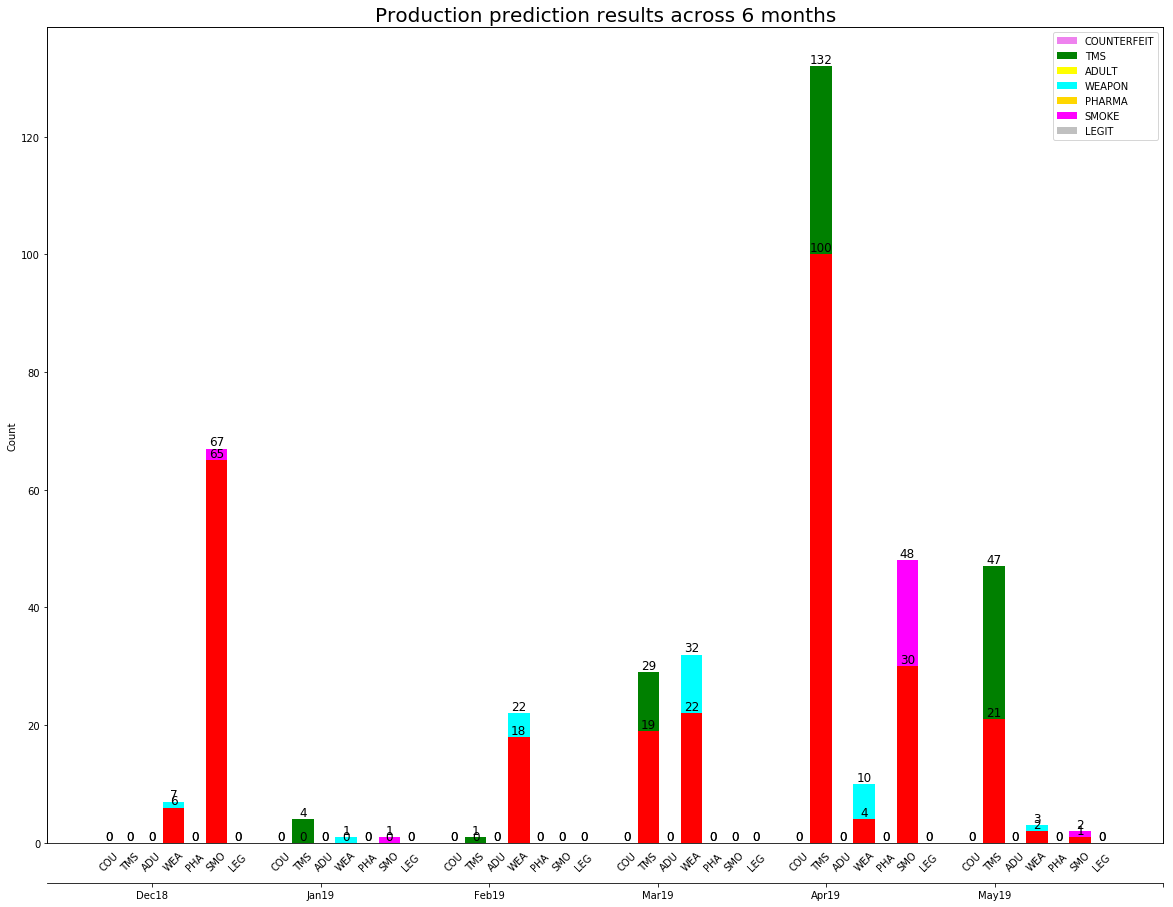

In [197]:
# Clean version

def autolabel(*args):
    
    def autolabel_base(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                    ha='center', va='bottom', fontsize=12)

    if len(args) > 1:
        rects1 = args[0]
        rects2 = args[1]
        intext = args[2][:3]
        
        for rect,rect2 in zip(rects1, rects2):
            #print('r2', rect2)
            h = rect.get_height()
            h2 = rect2.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., (h+h2), '%d'%int(h+h2),
                    ha='center', va='bottom', fontsize=12)
            ax.text(rect.get_x() + rect.get_width()/2., -5,intext, ha='center', va='bottom', rotation=45)
    else:
        autolabel_base(args[0])
        
import numpy as np
import matplotlib.pyplot as plt

x = ['Dec18', 'Jan19', 'Feb19', 'Mar19', 'Apr19', 'May19']
colors = ["violet", "green", "yellow", "aqua", "gold", "magenta", 'silver']

ind = np.arange(len(x)) # the x locations for the groups
width = 0.125       # the width of the bars

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_title('Production prediction results across 6 months',
             fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax.set_ylabel('Count')
ax.set_xticks([])

rects_list = []
for count, key in enumerate(list(prod_y.keys())):
    
    #Plotting count of FPs and for each category across each month
    yfp = is_fp_prod[key]
    yvals = prod_y[key]#[list(prod_y.values())[i][0] for i in range(6)]
    temp_fp = ax.bar(ind + width*count, yfp, width, color='r')
    temp_rects = ax.bar(
        ind + width*count, 
        [yvals[i]-yfp[i] for i in range(len(yvals))],
        width,
        color=colors[count],bottom=yfp)
    
    rects_list.append(temp_rects)
    autolabel(temp_rects, temp_fp, key)
    autolabel(temp_fp)
  

ax.legend( rects_list, att_y.keys())

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
#centre_bar_pos = [rec.get_x() for rec in rects_list[3]]
ax2.set_xticks([i+width*5 for i in range(0,7)])
ax2.set_xticklabels( x )
    
plt.show()

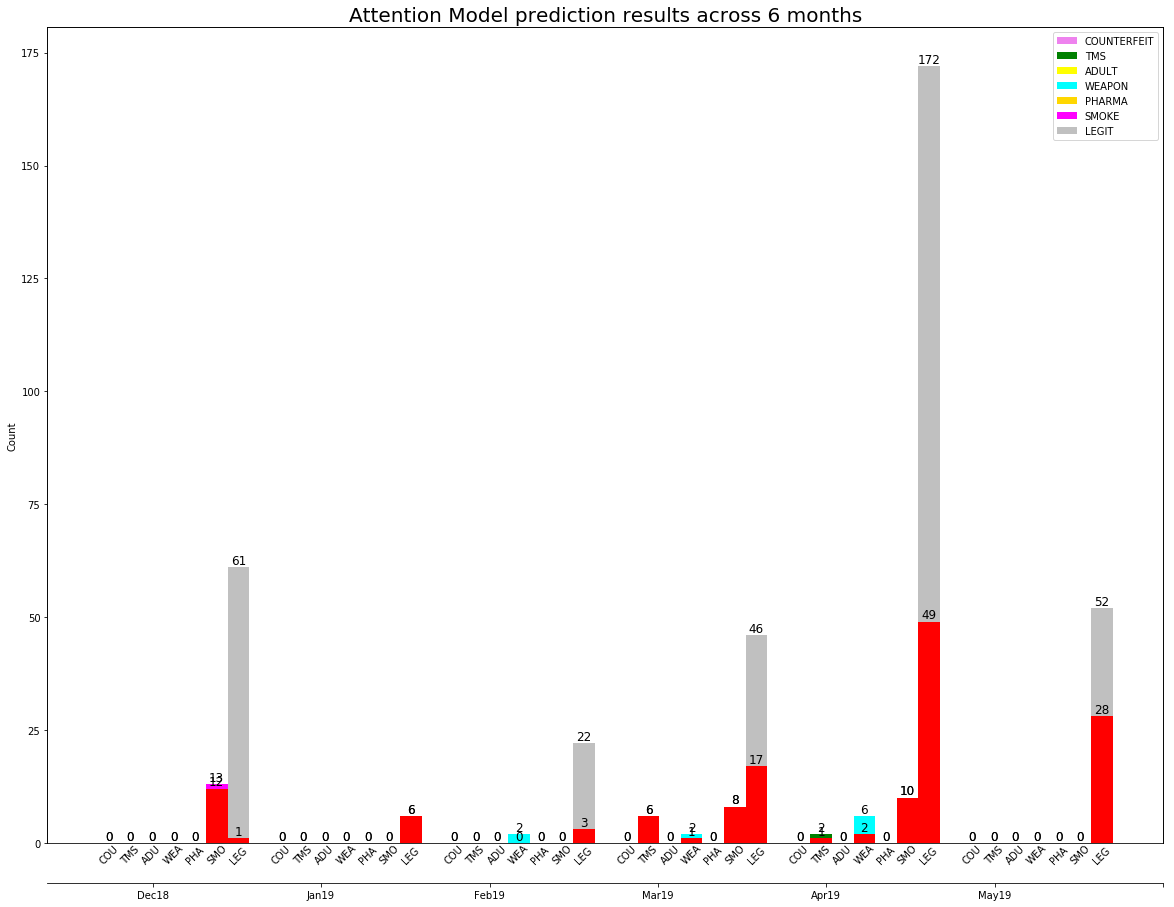

In [198]:
# Clean version

def autolabel(*args):
    
    def autolabel_base(rects):
        for rect in rects:
            h = rect.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., h, '%d'%int(h),
                    ha='center', va='bottom', fontsize=12)

    if len(args) > 1:
        rects1 = args[0]
        rects2 = args[1]
        intext = args[2][:3]
        
        for rect,rect2 in zip(rects1, rects2):
            #print('r2', rect2)
            h = rect.get_height()
            h2 = rect2.get_height()
            ax.text(rect.get_x()+rect.get_width()/2., (h+h2), '%d'%int(h+h2),
                    ha='center', va='bottom', fontsize=12)
            ax.text(rect.get_x() + rect.get_width()/2., -5,intext, ha='center', va='bottom', rotation=45)
    else:
        autolabel_base(args[0])
        
import numpy as np
import matplotlib.pyplot as plt

x = ['Dec18', 'Jan19', 'Feb19', 'Mar19', 'Apr19', 'May19']
colors = ["violet", "green", "yellow", "aqua", "gold", "magenta", "silver"]

ind = np.arange(len(x)) # the x locations for the groups
width = 0.125       # the width of the bars

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111)
ax.set_title('Attention Model prediction results across 6 months',
             fontdict={'fontsize': 20, 'fontweight': 'medium'})

ax.set_ylabel('Count')
ax.set_xticks([])


rects_list = []
for count, key in enumerate(list(prod_y.keys())):
    #Plotting count of FPs and for each category across each month
    yfp = is_fp_att[key]
    yvals = att_y[key]#[list(prod_y.values())[i][0] for i in range(6)]
    temp_fp = ax.bar(ind + width*count, yfp, width, color='r')
    temp_rects = ax.bar(
        ind + width*count, 
        [yvals[i]-yfp[i] for i in range(len(yvals))],
        width,
        color=colors[count],
        bottom=yfp)

    rects_list.append(temp_rects)
    autolabel(temp_rects, temp_fp, key)
    autolabel(temp_fp)
    
#Plot the modified legit cat

# ax.bar( ind + width, 
#         is_res_mod,
#         width,
#         color='pink')

ax.legend( rects_list, att_y.keys())

ax2 = ax.twiny()
ax2.xaxis.set_ticks_position('bottom')
ax2.spines['bottom'].set_position(('outward', 40))
centre_bar_pos = [rec.get_x() for rec in rects_list[0]]
ax2.set_xticks([i+width*5 for i in range(0,7)])#[centre_bar_pos[i]+width for i in range(6)])#ind+width*2)#[ind[i] + centre_bar_pos[i] for i in range(6)])
ax2.set_xticklabels( x )
    
plt.show()